In [4]:
import os
import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_means = np.load("/Users/jianda/Projects/nncam_training/consts/all_means.npz")
data_stds = np.load("/Users/jianda/Projects/nncam_training/consts/all_stds.npz")
print(data_means["QL"])
print(data_stds["QL"])



0.0019456508359358474
0.0038803161155459218


In [2]:
sample_data = nc.Dataset("/Users/jianda/Projects/experience_replay_data/noer1117/replay_buffer_spinup5_seed1117_sample2_noprevQT_mix1.0_std_rbs0/nc_files/conv_mem_share3.cam.h0.1998-01-01-01800.nc")

In [3]:
sample_data.variables["QL"]

<class 'netCDF4._netCDF4.Variable'>
float32 QL(time, lev, lat, lon)
    mdims: 1
    units: g/g
    long_name: CRM-Input global grid water vapor
unlimited dimensions: time
current shape = (1, 30, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

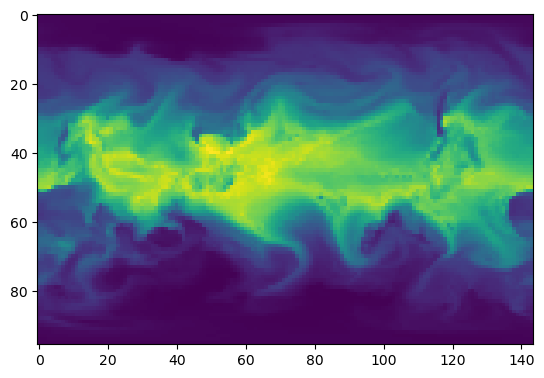

In [5]:
plt.imshow(sample_data.variables["Q"][0,28,:,:])

In [7]:
sample_data.variables["Q"]

<class 'netCDF4._netCDF4.Variable'>
float32 Q(time, lev, lat, lon)
    mdims: 1
    units: kg/kg
    long_name: Specific humidity
unlimited dimensions: time
current shape = (1, 30, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

In [8]:
sample_data.variables["QL"]

<class 'netCDF4._netCDF4.Variable'>
float32 QL(time, lev, lat, lon)
    mdims: 1
    units: g/g
    long_name: CRM-Input global grid water vapor
unlimited dimensions: time
current shape = (1, 30, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

In [10]:
assert np.allclose(sample_data.variables["Q"][0,28,:,:], sample_data.variables["QL"][0,28,:,:])

AssertionError: 

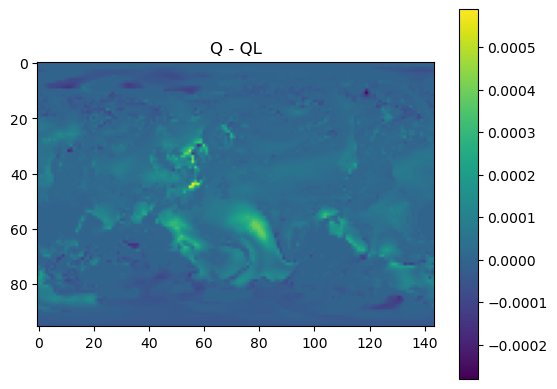

In [11]:
diff = sample_data.variables["Q"][0,28,:,:] - sample_data.variables["QL"][0,28,:,:]
plt.imshow(diff)
plt.colorbar()
plt.title("Q - QL")
plt.show()


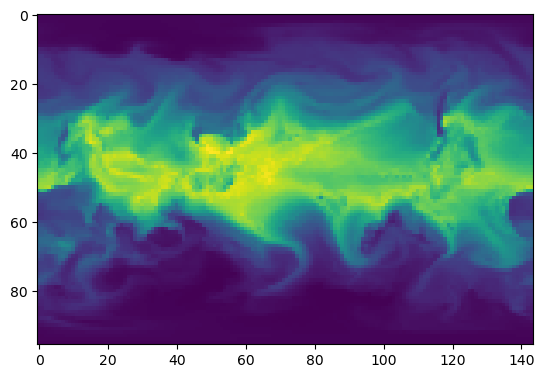

In [ ]:
plt.imshow(sample_data.variables["QL"][0,28,:,:])

In [16]:
crash_data_path = "/Volumes/data_backup/experience_replay_data/replay_buffer_spinup5_seed1117_sample2_noprevQT_mix1.0_std_rbs0/nc_files/"
h0_files = [f for f in os.listdir(crash_data_path) if "h0" in f and not f.startswith(".")]
h0_files.sort()
for fn in h0_files:
    print(fn)

conv_mem_share3.cam.h0.1998-01-01-00000.nc
conv_mem_share3.cam.h0.1998-01-01-01800.nc
conv_mem_share3.cam.h0.1998-01-01-03600.nc
conv_mem_share3.cam.h0.1998-01-01-05400.nc
conv_mem_share3.cam.h0.1998-01-01-07200.nc
conv_mem_share3.cam.h0.1998-01-01-09000.nc
conv_mem_share3.cam.h0.1998-01-01-10800.nc
conv_mem_share3.cam.h0.1998-01-01-12600.nc
conv_mem_share3.cam.h0.1998-01-01-14400.nc
conv_mem_share3.cam.h0.1998-01-01-16200.nc
conv_mem_share3.cam.h0.1998-01-01-18000.nc
conv_mem_share3.cam.h0.1998-01-01-19800.nc
conv_mem_share3.cam.h0.1998-01-01-21600.nc
conv_mem_share3.cam.h0.1998-01-01-23400.nc
conv_mem_share3.cam.h0.1998-01-01-25200.nc
conv_mem_share3.cam.h0.1998-01-01-27000.nc
conv_mem_share3.cam.h0.1998-01-01-28800.nc
conv_mem_share3.cam.h0.1998-01-01-30600.nc
conv_mem_share3.cam.h0.1998-01-01-32400.nc
conv_mem_share3.cam.h0.1998-01-01-34200.nc
conv_mem_share3.cam.h0.1998-01-01-36000.nc
conv_mem_share3.cam.h0.1998-01-01-37800.nc
conv_mem_share3.cam.h0.1998-01-01-39600.nc
conv_mem_sh

In [46]:
for fn in h0_files:
    data = nc.Dataset(os.path.join(crash_data_path, fn))
    QL = data.variables["QL"][0,28,:,:]
    if np.all(QL == 0):
        # print(f"QL is all 0 in {fn}")
        continue
    print(QL.mean())
    Q = data.variables["Q"][0,28,:,:]
    print("Q:", Q.mean())
    # plt.imshow(data.variables["QL"][0,28,:,:])
    # plt.colorbar()
    # plt.title(f"QL level 28 - {fn}")
    # plt.show()

0.006633497
Q: 0.0066518807
0.0066441586
Q: 0.006697989
0.006689411
Q: 0.006731283
0.006722721
Q: 0.0067268126
0.0067187566
Q: 0.0066911685
0.0066836188
Q: 0.006629247


IndexError: index exceeds dimension bounds

In [47]:
def reorder(data, pver):
    # data[lon*lat, pver]
    lon_p = 24
    lat_p = 3
    # lon_num = 6
    # lat_num = 32

    ret = np.empty([144*96, pver])

    start_lon = 0  # (st: st+lon_p)
    start_lat = 0  # (st: st+lat_p)
    idx = 0

    for i in range(192):
        for lat_i in range(0, lat_p):
            for lon_i in range(0, lon_p):
                lon_idx = start_lon + lon_i
                lat_idx = start_lat + lat_i
                new_idx = lat_idx * 144 + lon_idx
                for k in range(0, pver):
                    ret[new_idx][k] = data[idx][k]
                idx = idx + 1
        start_lon = start_lon + lon_p
        if (start_lon == 144):
            start_lon = 0
            start_lat = start_lat + lat_p

    return ret


In [179]:
def reorder2(data, pver):
    # data[lon*lat, pver]
    lon_p = 24
    lat_p = 3
    # lon_num = 6
    # lat_num = 32

    ret = np.empty([144*96, pver])

    start_lon = 0  # (st: st+lon_p)
    start_lat = 0  # (st: st+lat_p)
    idx = 0

    for i in range(192):
        for lat_i in range(0, lat_p):
            for lon_i in range(0, lon_p):
                lon_idx = start_lon + lon_i
                lat_idx = start_lat + lat_i
                new_idx = lat_idx * 144 + lon_idx
                for k in range(0, pver):
                    ret[new_idx][k] = data[idx][k]
                idx = idx + 1
        # start_lon = start_lon + lon_p
        start_lat = start_lat + lat_p
        if (start_lat == 96):
            start_lat = 0
            start_lat = start_lat + lat_p

    return ret


(13824,)
0.006510656169765059


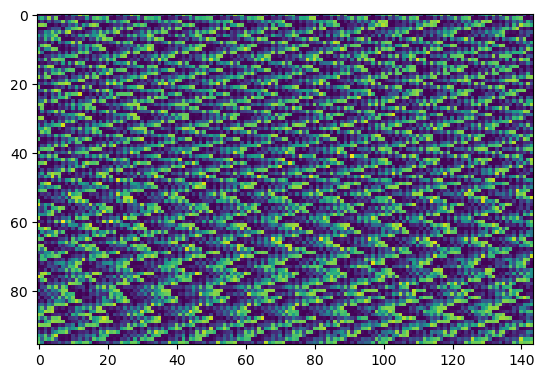

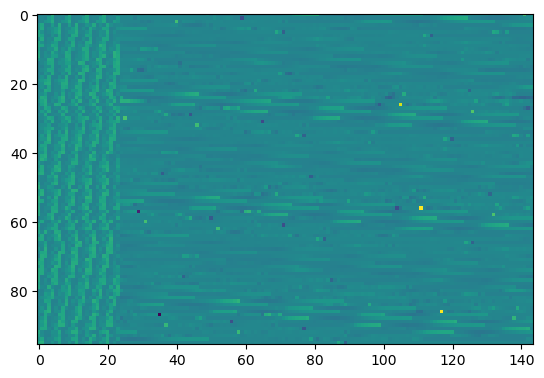

In [180]:
npz_path = "/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/"
npz_files = [f for f in os.listdir(npz_path) if f.endswith(".npz") and "pred" not in f and not f.startswith(".")]
npz_files.sort()
for fn in npz_files:
    data = np.load(os.path.join(npz_path, fn))
    x = data["x"]
    QL = x[:,28].reshape(96,144)
    print(x[:,28].shape)
    reorder_QL = reorder2(x[:,28,None], 1)
    reorder_QL = reorder_QL.reshape(96,144)
    print(QL.mean()*data_stds["QL"]+data_means["QL"])
    # if np.all(QL == 0):
    #     # print(f"QL is all 0 in {fn}")
    #     continue
    plt.imshow(QL)
    plt.show()
    plt.imshow(reorder_QL)
    plt.show()
    break
    # plt.colorbar()
    # plt.title(f"QL level 28 - {fn}")
    # plt.show()


In [167]:
sample_data2 = np.load("/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_4.npz")["x"][:,29]
sample_data2 = sample_data2.reshape(96,144) * data_stds["QL"] + data_means["QL"]
print(sample_data2.shape)
print(sample_data2.mean())
print(sample_data2.std())

(96, 144)
0.007357672658489364
0.0067048898879449245


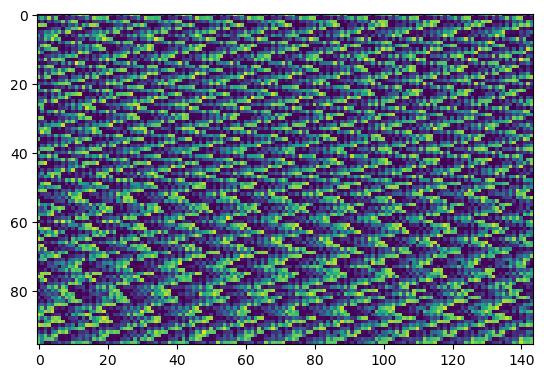

In [168]:
plt.imshow(sample_data2)
plt.show()


In [170]:
np.save("python_output.npy", sample_data2)

In [171]:
sample_data1 = nc.Dataset("/Volumes/data_backup/experience_replay_data/replay_buffer_spinup5_seed1117_sample2_noprevQT_mix1.0_std_rbs0/nc_files/conv_mem_share3.cam.h0.1998-01-01-05400.nc").variables["QL"][0,29,:,:]
print(sample_data1.shape)
print(sample_data1.mean())
print(sample_data1.std())

(96, 144)
0.0073576723
0.00670489


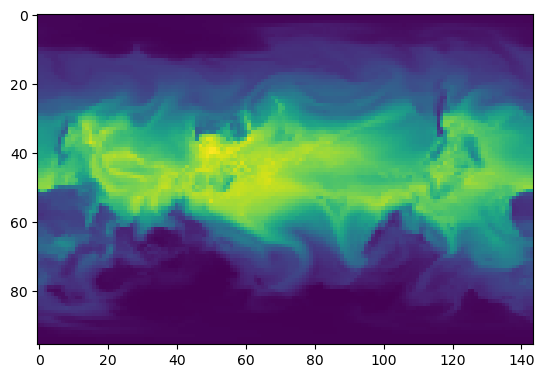

In [172]:
plt.imshow(sample_data1)

In [174]:
np.save("cesm_output.npy", sample_data1.data)

(96, 144)
0.007357672658489364
0.0067048898879449245


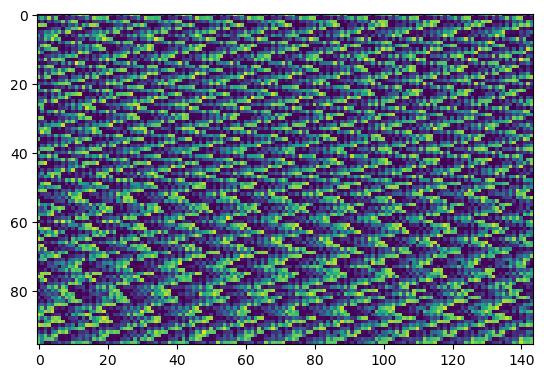

(96, 144)
0.0073576723
0.00670489


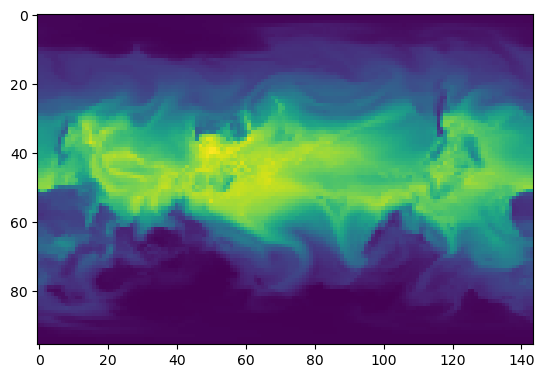

In [178]:
test1 = np.load("python_output.npy")
test2 = np.load("cesm_output.npy")
print(test1.shape)
print(test1.mean())
print(test1.std())
plt.imshow(test1)
plt.show()
print(test2.shape)
print(test2.mean())
print(test2.std())
plt.imshow(test2)
plt.show()


tensor(2.9802e-08)
tensor(-7.7817e-08)
Epoch [200/100000], Loss: -0.6769
Epoch [400/100000], Loss: -0.8406
Epoch [600/100000], Loss: -0.8776
Epoch [800/100000], Loss: -0.8946
Epoch [1000/100000], Loss: -0.9045
Epoch [1200/100000], Loss: -0.9126
Epoch [1400/100000], Loss: -0.9194
Epoch [1600/100000], Loss: -0.9220
Epoch [1800/100000], Loss: -0.9241
Epoch [2000/100000], Loss: -0.9274
Epoch [2200/100000], Loss: -0.9297
Epoch [2400/100000], Loss: -0.9311
Epoch [2600/100000], Loss: -0.9325
Epoch [2800/100000], Loss: -0.9339
Epoch [3000/100000], Loss: -0.9347
Epoch [3200/100000], Loss: -0.9371
Epoch [3400/100000], Loss: -0.9387
Epoch [3600/100000], Loss: -0.9400
Epoch [3800/100000], Loss: -0.9408
Epoch [4000/100000], Loss: -0.9422
Epoch [4200/100000], Loss: -0.9433
Epoch [4400/100000], Loss: -0.9440
Epoch [4600/100000], Loss: -0.9449
Epoch [4800/100000], Loss: -0.9455
Epoch [5000/100000], Loss: -0.9464
Epoch [5200/100000], Loss: -0.9472
Epoch [5400/100000], Loss: -0.9477
Epoch [5600/100000],

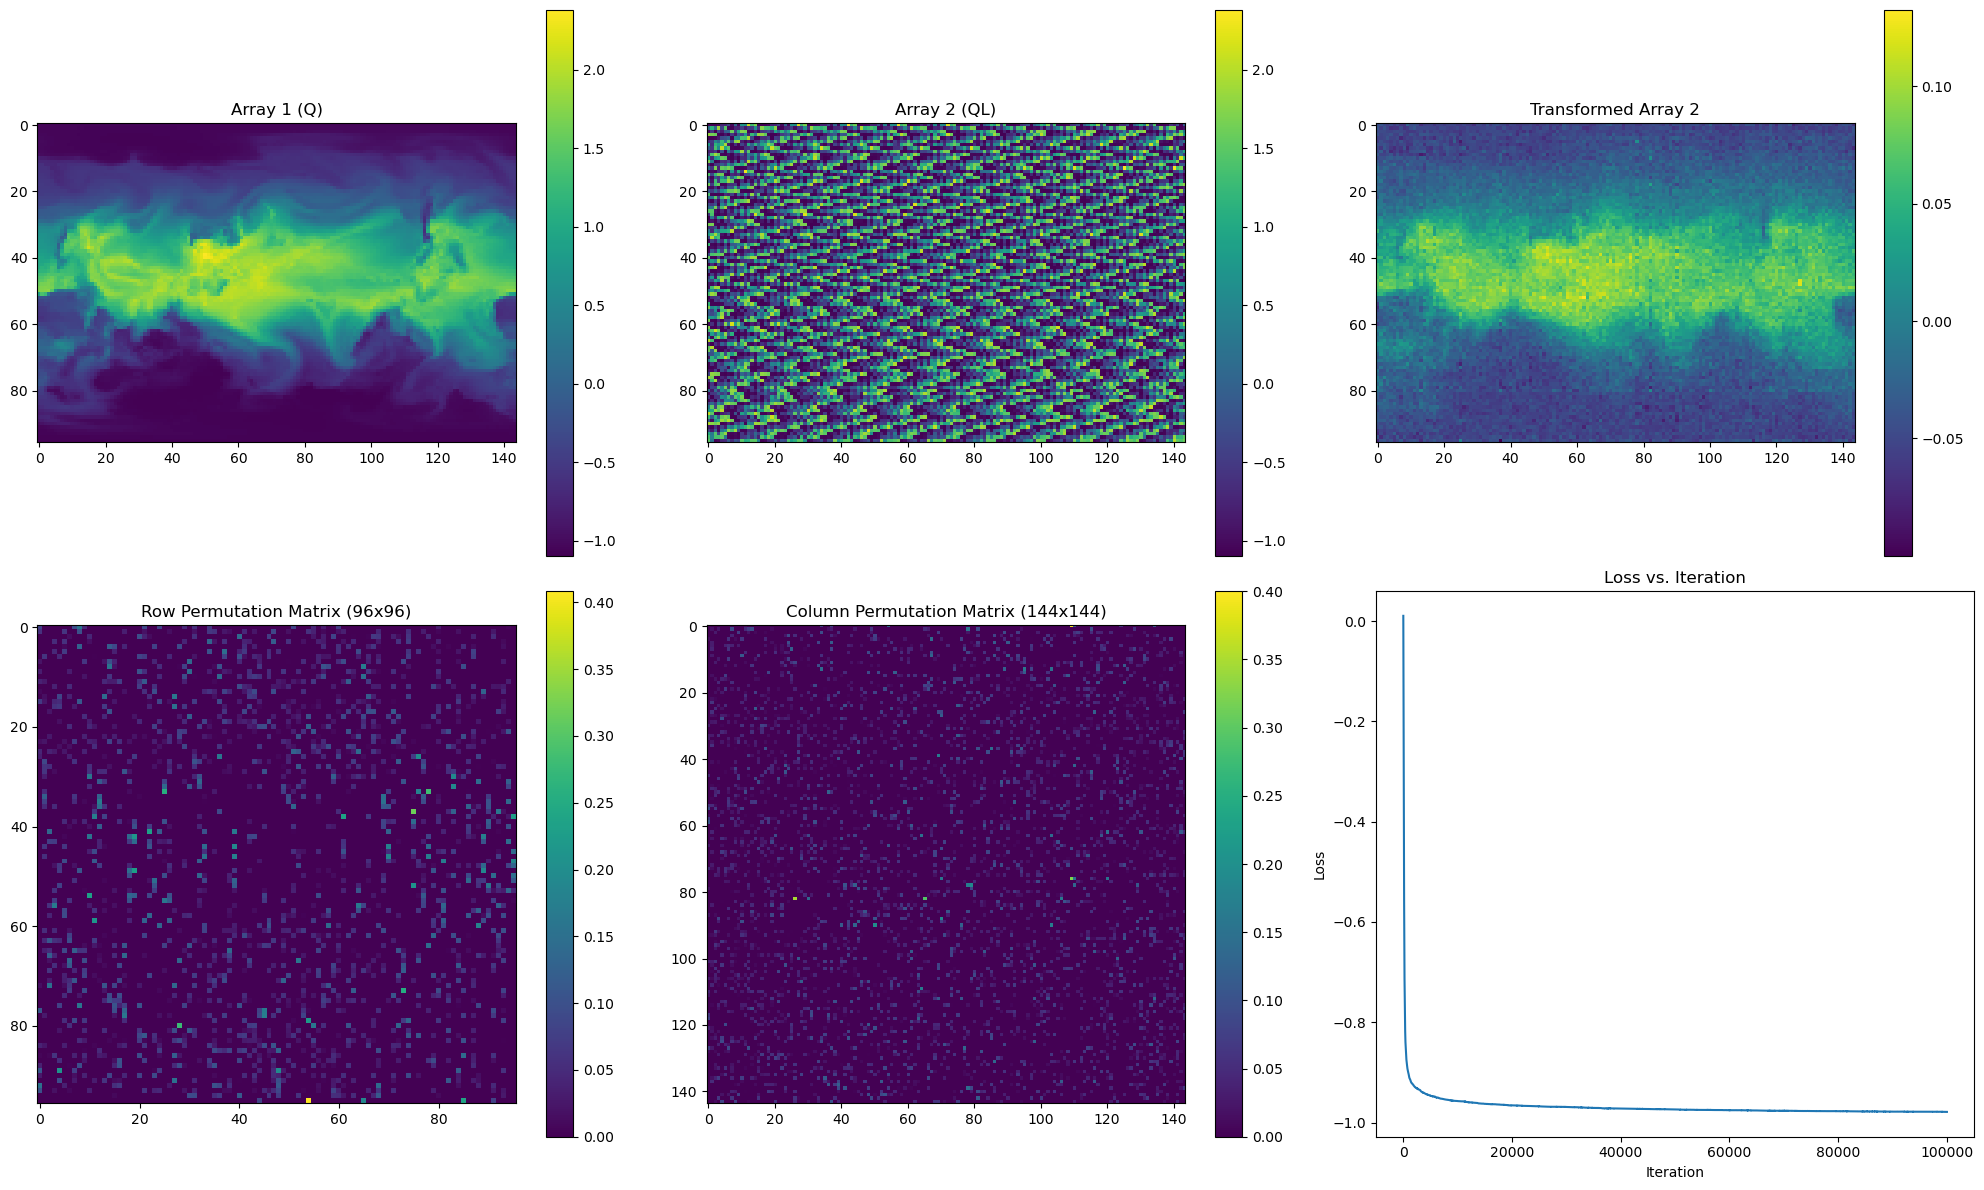

Original correlation: -0.022
Transformed correlation: 0.979

First few row permutation indices: [ 8  8 40 34  8 37 40 30 65 30]
First few column permutation indices: [109  78  89  24  67  37  97  25  67  67]


In [76]:


def sinkhorn(Q, n_iterations=20, temperature=0.1):
    """
    Sinkhorn-Knopp algorithm for computing soft permutation matrices
    """
    Q = torch.exp(Q / temperature)
    for _ in range(n_iterations):
        Q = Q / (Q.sum(dim=0, keepdim=True) + 1e-8)
        Q = Q / (Q.sum(dim=1, keepdim=True) + 1e-8)
    return Q

class SpatialTransformer(torch.nn.Module):
    def __init__(self, n_rows, n_cols):
        super().__init__()
        # Initialize separate transformations for rows and columns
        self.row_transform = torch.nn.Parameter(torch.randn(n_rows, n_rows))
        self.col_transform = torch.nn.Parameter(torch.randn(n_cols, n_cols))
        
    def forward(self, x):
        # Get soft permutation matrices
        row_perm = sinkhorn(self.row_transform)
        col_perm = sinkhorn(self.col_transform)
        
        # Apply transformations
        x = torch.matmul(row_perm, x)
        x = torch.matmul(x, col_perm.t())
        return x

# Convert your data to torch tensors
array1 = torch.tensor(sample_data1, dtype=torch.float32)
array2 = torch.tensor(sample_data2, dtype=torch.float32)

# Normalize the data
array1 = (array1 - array1.mean()) / array1.std()
print(array1.mean())
array2 = (array2 - array2.mean()) / array2.std()
print(array2.mean())

# Initialize transformer and optimizer
transformer = SpatialTransformer(96, 144)  # Using correct dimensions
optimizer = Adam(transformer.parameters(), lr=0.01)

# Training loop
n_epochs = 100000  # Increased epochs for better convergence
losses = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Transform array2
    transformed = transformer(array2)
    
    # Compute loss (negative correlation)
    loss = -F.cosine_similarity(array1.flatten(), transformed.flatten(), dim=0)
    
    # Backward and optimize
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Get final transformation
with torch.no_grad():
    final_transformed = transformer(array2)
    row_perm = sinkhorn(transformer.row_transform)
    col_perm = sinkhorn(transformer.col_transform)

# Convert back to numpy for visualization
final_transformed = final_transformed.numpy()
row_perm = row_perm.numpy()
col_perm = col_perm.numpy()

# Visualize results
plt.figure(figsize=(20, 12))

# Original arrays
plt.subplot(231)
plt.imshow(array1.numpy())
plt.title('Array 1 (Q)')
plt.colorbar()

plt.subplot(232)
plt.imshow(array2.numpy())
plt.title('Array 2 (QL)')
plt.colorbar()

plt.subplot(233)
plt.imshow(final_transformed)
plt.title('Transformed Array 2')
plt.colorbar()

# Permutation matrices (with correct aspect ratios)
plt.subplot(234)
plt.imshow(row_perm)
plt.title('Row Permutation Matrix (96x96)')
plt.colorbar()

plt.subplot(235)
plt.imshow(col_perm)
plt.title('Column Permutation Matrix (144x144)')
plt.colorbar()

# Loss curve
plt.subplot(236)
plt.plot(losses)
plt.title('Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Print final correlation
original_corr = np.corrcoef(array1.numpy().flatten(), array2.numpy().flatten())[0,1]
transformed_corr = np.corrcoef(array1.numpy().flatten(), final_transformed.flatten())[0,1]
print(f"Original correlation: {original_corr:.3f}")
print(f"Transformed correlation: {transformed_corr:.3f}")

# To get hard permutation matrices (if needed)
row_perm_hard = row_perm.argmax(axis=1)
col_perm_hard = col_perm.argmax(axis=1)
print("\nFirst few row permutation indices:", row_perm_hard[:10])
print("First few column permutation indices:", col_perm_hard[:10])

In [25]:
def sinkhorn(Q, n_iterations=20, temperature=0.1):
    """
    Sinkhorn-Knopp algorithm with improved numerical stability
    """
    # Clip values to avoid overflow in exp
    Q = torch.clamp(Q, min=-100, max=100)
    Q = torch.exp(Q / temperature)
    
    for _ in range(n_iterations):
        # Add small epsilon to avoid division by zero
        Q = Q / (Q.sum(dim=0, keepdim=True) + 1e-10)
        Q = Q / (Q.sum(dim=1, keepdim=True) + 1e-10)
        
        # Clip values to avoid numerical instability
        Q = torch.clamp(Q, min=1e-20, max=1e20)
    return Q

class SpatialTransformer(torch.nn.Module):
    def __init__(self, n_rows, n_cols):
        super().__init__()
        # Initialize separate transformations for rows and columns
        self.row_transform = torch.nn.Parameter(torch.randn(n_rows, n_rows))
        self.col_transform = torch.nn.Parameter(torch.randn(n_cols, n_cols))
        
    def forward(self, x):
        # Get soft permutation matrices
        row_perm = sinkhorn(self.row_transform)
        col_perm = sinkhorn(self.col_transform)
        
        # Apply transformations
        x = torch.matmul(row_perm, x)
        x = torch.matmul(x, col_perm.t())
        return x
    def get_state_dict(self):
        """Return a deep copy of model state"""
        return {
            'row_transform': self.row_transform.data.clone(),
            'col_transform': self.col_transform.data.clone()
        }
    
    def load_state_dict(self, state_dict):
        """Load saved state"""
        self.row_transform.data = state_dict['row_transform'].clone()
        self.col_transform.data = state_dict['col_transform'].clone()

# Convert your data to torch tensors
array1 = torch.tensor(sample_data1, dtype=torch.float32)
array2 = torch.tensor(sample_data2, dtype=torch.float32)

# Normalize the data
array1 = (array1 - array1.mean()) / array1.std()
print(array1.mean())
array2 = (array2 - array2.mean()) / array2.std()
print(array2.mean())

# Initialize transformer and optimizer
transformer = SpatialTransformer(96, 144)  # Using correct dimensions
optimizer = Adam(transformer.parameters(), lr=0.01)

# Training parameters
initial_temp = 0.1
final_temp = 0.1  # Increased minimum temperature
n_epochs = 100000
temp_decay = np.exp(np.log(final_temp/initial_temp)/(n_epochs-1))

# Reset optimizer with smaller learning rate
optimizer = Adam(transformer.parameters(), lr=0.001)  # Reduced learning rate

losses = []
temperatures = []
current_temp = initial_temp
best_model_state = None, None
best_loss = float('inf')
patience = 1000  # Early stopping patience
no_improvement = 0

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Update temperature
    current_temp = initial_temp * (temp_decay ** epoch)
    
    # Transform array2 with current temperature
    try:
        row_perm = sinkhorn(transformer.row_transform, temperature=current_temp)
        col_perm = sinkhorn(transformer.col_transform, temperature=current_temp)
        transformed = torch.matmul(row_perm, array2)
        transformed = torch.matmul(transformed, col_perm.t())
        
        # Compute loss with gradient clipping
        loss = -F.cosine_similarity(array1.flatten(), transformed.flatten(), dim=0)
        # loss = F.mse_loss(array1.flatten(), transformed.flatten())
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Skipping update.")
            continue
            
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        current_loss = loss.item()
        losses.append(current_loss)
        temperatures.append(current_temp)

        # Save best model
        if current_loss < best_loss:
            best_loss = current_loss
            best_model_state = transformer.get_state_dict(), current_temp
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {current_loss:.4f}, Temp: {current_temp:.6f}')
            
    except RuntimeError as e:
        print(f"Error at epoch {epoch+1}: {str(e)}")
        break

tensor(2.9802e-08)
tensor(-7.7817e-08)
Epoch [200/100000], Loss: -0.1191, Temp: 0.100000
Epoch [400/100000], Loss: -0.3625, Temp: 0.100000
Epoch [600/100000], Loss: -0.6154, Temp: 0.100000
Epoch [800/100000], Loss: -0.7682, Temp: 0.100000
Epoch [1000/100000], Loss: -0.8446, Temp: 0.100000
Epoch [1200/100000], Loss: -0.8773, Temp: 0.100000
Epoch [1400/100000], Loss: -0.8918, Temp: 0.100000
Epoch [1600/100000], Loss: -0.9023, Temp: 0.100000
Epoch [1800/100000], Loss: -0.9110, Temp: 0.100000
Epoch [2000/100000], Loss: -0.9165, Temp: 0.100000
Epoch [2200/100000], Loss: -0.9224, Temp: 0.100000
Epoch [2400/100000], Loss: -0.9266, Temp: 0.100000
Epoch [2600/100000], Loss: -0.9293, Temp: 0.100000
Epoch [2800/100000], Loss: -0.9325, Temp: 0.100000
Epoch [3000/100000], Loss: -0.9352, Temp: 0.100000
Epoch [3200/100000], Loss: -0.9375, Temp: 0.100000
Epoch [3400/100000], Loss: -0.9401, Temp: 0.100000
Epoch [3600/100000], Loss: -0.9409, Temp: 0.100000
Epoch [3800/100000], Loss: -0.9418, Temp: 0.100

In [27]:
# def sinkhorn(Q, n_iterations=20, temperature=0.1):
#     """
#     Sinkhorn-Knopp algorithm with improved numerical stability
#     """
#     # Clip values to avoid overflow in exp
#     Q = torch.clamp(Q, min=-100, max=100)
#     Q = torch.exp(Q / temperature)
    
#     for _ in range(n_iterations):
#         # Add small epsilon to avoid division by zero
#         Q = Q / (Q.sum(dim=0, keepdim=True) + 1e-10)
#         Q = Q / (Q.sum(dim=1, keepdim=True) + 1e-10)
        
#         # Clip values to avoid numerical instability
#         Q = torch.clamp(Q, min=1e-20, max=1e20)
#     return Q

# class SpatialTransformer(torch.nn.Module):
#     def __init__(self, n_rows, n_cols):
#         super().__init__()
#         # Initialize separate transformations for rows and columns
#         self.row_transform = torch.nn.Parameter(torch.randn(n_rows, n_rows))
#         self.col_transform = torch.nn.Parameter(torch.randn(n_cols, n_cols))
        
#     def forward(self, x):
#         # Get soft permutation matrices
#         row_perm = sinkhorn(self.row_transform)
#         col_perm = sinkhorn(self.col_transform)
        
#         # Apply transformations
#         x = torch.matmul(row_perm, x)
#         x = torch.matmul(x, col_perm.t())
#         return x
#     def get_state_dict(self):
#         """Return a deep copy of model state"""
#         return {
#             'row_transform': self.row_transform.data.clone(),
#             'col_transform': self.col_transform.data.clone()
#         }
    
#     def load_state_dict(self, state_dict):
#         """Load saved state"""
#         self.row_transform.data = state_dict['row_transform'].clone()
#         self.col_transform.data = state_dict['col_transform'].clone()

# Convert your data to torch tensors
array1 = torch.tensor(sample_data1, dtype=torch.float32)
array2 = torch.tensor(sample_data2, dtype=torch.float32)

# Normalize the data
array1 = (array1 - array1.mean()) / array1.std()
print(array1.mean())
array2 = (array2 - array2.mean()) / array2.std()
print(array2.mean())

# # Initialize transformer and optimizer
# transformer = SpatialTransformer(96, 144)  # Using correct dimensions
# optimizer = Adam(transformer.parameters(), lr=0.01)

# Training parameters
initial_temp = 0.1
final_temp = 0.1  # Increased minimum temperature
n_epochs = 100000
temp_decay = np.exp(np.log(final_temp/initial_temp)/(n_epochs-1))

# Reset optimizer with smaller learning rate
# optimizer = Adam(transformer.parameters(), lr=0.001)  # Reduced learning rate

losses = []
temperatures = []
current_temp = initial_temp
# best_model_state = None, None
# best_loss = float('inf')
patience = 1000  # Early stopping patience
no_improvement = 0

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Update temperature
    current_temp = initial_temp * (temp_decay ** epoch)
    
    # Transform array2 with current temperature
    try:
        row_perm = sinkhorn(transformer.row_transform, temperature=current_temp)
        col_perm = sinkhorn(transformer.col_transform, temperature=current_temp)
        transformed = torch.matmul(row_perm, array2)
        transformed = torch.matmul(transformed, col_perm.t())
        
        # Compute loss with gradient clipping
        loss = -F.cosine_similarity(array1.flatten(), transformed.flatten(), dim=0)
        # loss = F.mse_loss(array1.flatten(), transformed.flatten())
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Skipping update.")
            continue
            
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        current_loss = loss.item()
        losses.append(current_loss)
        temperatures.append(current_temp)

        # Save best model
        if current_loss < best_loss:
            best_loss = current_loss
            best_model_state = transformer.get_state_dict(), current_temp
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {current_loss:.4f}, Temp: {current_temp:.6f}')
            
    except RuntimeError as e:
        print(f"Error at epoch {epoch+1}: {str(e)}")
        break

tensor(2.9802e-08)
tensor(-7.7817e-08)
Epoch [200/100000], Loss: -0.9824, Temp: 0.100000
Epoch [400/100000], Loss: -0.9824, Temp: 0.100000
Epoch [600/100000], Loss: -0.9824, Temp: 0.100000
Epoch [800/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1000/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1200/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1400/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1600/100000], Loss: -0.9825, Temp: 0.100000
Epoch [1800/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2000/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2200/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2400/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2600/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2800/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3000/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3200/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3400/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3600/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3800/100000], Loss: -0.9825, Temp: 0.100

In [ ]:
# def sinkhorn(Q, n_iterations=20, temperature=0.1):
#     """
#     Sinkhorn-Knopp algorithm with improved numerical stability
#     """
#     # Clip values to avoid overflow in exp
#     Q = torch.clamp(Q, min=-100, max=100)
#     Q = torch.exp(Q / temperature)
    
#     for _ in range(n_iterations):
#         # Add small epsilon to avoid division by zero
#         Q = Q / (Q.sum(dim=0, keepdim=True) + 1e-10)
#         Q = Q / (Q.sum(dim=1, keepdim=True) + 1e-10)
        
#         # Clip values to avoid numerical instability
#         Q = torch.clamp(Q, min=1e-20, max=1e20)
#     return Q

# class SpatialTransformer(torch.nn.Module):
#     def __init__(self, n_rows, n_cols):
#         super().__init__()
#         # Initialize separate transformations for rows and columns
#         self.row_transform = torch.nn.Parameter(torch.randn(n_rows, n_rows))
#         self.col_transform = torch.nn.Parameter(torch.randn(n_cols, n_cols))
        
#     def forward(self, x):
#         # Get soft permutation matrices
#         row_perm = sinkhorn(self.row_transform)
#         col_perm = sinkhorn(self.col_transform)
        
#         # Apply transformations
#         x = torch.matmul(row_perm, x)
#         x = torch.matmul(x, col_perm.t())
#         return x
#     def get_state_dict(self):
#         """Return a deep copy of model state"""
#         return {
#             'row_transform': self.row_transform.data.clone(),
#             'col_transform': self.col_transform.data.clone()
#         }
    
#     def load_state_dict(self, state_dict):
#         """Load saved state"""
#         self.row_transform.data = state_dict['row_transform'].clone()
#         self.col_transform.data = state_dict['col_transform'].clone()

# Convert your data to torch tensors
array1 = torch.tensor(sample_data1, dtype=torch.float32)
array2 = torch.tensor(sample_data2, dtype=torch.float32)

# Normalize the data
array1 = (array1 - array1.mean()) / array1.std()
print(array1.mean())
array2 = (array2 - array2.mean()) / array2.std()
print(array2.mean())

# # Initialize transformer and optimizer
# transformer = SpatialTransformer(96, 144)  # Using correct dimensions
# optimizer = Adam(transformer.parameters(), lr=0.01)

# Training parameters
initial_temp = 0.1
final_temp = 0.1  # Increased minimum temperature
n_epochs = 100000
temp_decay = np.exp(np.log(final_temp/initial_temp)/(n_epochs-1))

# Reset optimizer with smaller learning rate
# optimizer = Adam(transformer.parameters(), lr=0.001)  # Reduced learning rate

losses = []
temperatures = []
current_temp = initial_temp
# best_model_state = None, None
# best_loss = float('inf')
patience = 1000  # Early stopping patience
no_improvement = 0

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Update temperature
    current_temp = initial_temp * (temp_decay ** epoch)
    
    # Transform array2 with current temperature
    try:
        row_perm = sinkhorn(transformer.row_transform, temperature=current_temp)
        col_perm = sinkhorn(transformer.col_transform, temperature=current_temp)
        transformed = torch.matmul(row_perm, array2)
        transformed = torch.matmul(transformed, col_perm.t())
        
        # Compute loss with gradient clipping
        loss = -F.cosine_similarity(array1.flatten(), transformed.flatten(), dim=0)
        # loss = F.mse_loss(array1.flatten(), transformed.flatten())
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Skipping update.")
            continue
            
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        current_loss = loss.item()
        losses.append(current_loss)
        temperatures.append(current_temp)

        # Save best model
        if current_loss < best_loss:
            best_loss = current_loss
            best_model_state = transformer.get_state_dict(), current_temp
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {current_loss:.4f}, Temp: {current_temp:.6f}')
            
    except RuntimeError as e:
        print(f"Error at epoch {epoch+1}: {str(e)}")
        break

tensor(2.9802e-08)
tensor(-7.7817e-08)
Epoch [200/100000], Loss: -0.9824, Temp: 0.100000
Epoch [400/100000], Loss: -0.9824, Temp: 0.100000
Epoch [600/100000], Loss: -0.9824, Temp: 0.100000
Epoch [800/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1000/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1200/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1400/100000], Loss: -0.9824, Temp: 0.100000
Epoch [1600/100000], Loss: -0.9825, Temp: 0.100000
Epoch [1800/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2000/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2200/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2400/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2600/100000], Loss: -0.9825, Temp: 0.100000
Epoch [2800/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3000/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3200/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3400/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3600/100000], Loss: -0.9825, Temp: 0.100000
Epoch [3800/100000], Loss: -0.9825, Temp: 0.100

In [35]:
# Load the saved model state from file
model_path = "best_model_state0.982_0.1.pt"
if os.path.exists(model_path):
    saved_state = torch.load(model_path)
    transformer.load_state_dict(saved_state['model_state'])
    current_temp = saved_state['temperature']
    print(f"Loaded model state from {model_path} with temperature {current_temp:.6f}")
else:
    print(f"Could not find saved model state at {model_path}")


Loaded model state from best_model_state0.982_0.1.pt with temperature 0.100000


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_97821/453933120.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(model_path)


In [39]:
# def sinkhorn(Q, n_iterations=20, temperature=0.1):
#     """
#     Sinkhorn-Knopp algorithm with improved numerical stability
#     """
#     # Clip values to avoid overflow in exp
#     Q = torch.clamp(Q, min=-100, max=100)
#     Q = torch.exp(Q / temperature)
    
#     for _ in range(n_iterations):
#         # Add small epsilon to avoid division by zero
#         Q = Q / (Q.sum(dim=0, keepdim=True) + 1e-10)
#         Q = Q / (Q.sum(dim=1, keepdim=True) + 1e-10)
        
#         # Clip values to avoid numerical instability
#         Q = torch.clamp(Q, min=1e-20, max=1e20)
#     return Q

# class SpatialTransformer(torch.nn.Module):
#     def __init__(self, n_rows, n_cols):
#         super().__init__()
#         # Initialize separate transformations for rows and columns
#         self.row_transform = torch.nn.Parameter(torch.randn(n_rows, n_rows))
#         self.col_transform = torch.nn.Parameter(torch.randn(n_cols, n_cols))
        
#     def forward(self, x):
#         # Get soft permutation matrices
#         row_perm = sinkhorn(self.row_transform)
#         col_perm = sinkhorn(self.col_transform)
        
#         # Apply transformations
#         x = torch.matmul(row_perm, x)
#         x = torch.matmul(x, col_perm.t())
#         return x
#     def get_state_dict(self):
#         """Return a deep copy of model state"""
#         return {
#             'row_transform': self.row_transform.data.clone(),
#             'col_transform': self.col_transform.data.clone()
#         }
    
#     def load_state_dict(self, state_dict):
#         """Load saved state"""
#         self.row_transform.data = state_dict['row_transform'].clone()
#         self.col_transform.data = state_dict['col_transform'].clone()

# Convert your data to torch tensors
array1 = torch.tensor(sample_data1, dtype=torch.float32)
array2 = torch.tensor(sample_data2, dtype=torch.float32)

# Normalize the data
array1 = (array1 - array1.mean()) / array1.std()
print(array1.mean())
array2 = (array2 - array2.mean()) / array2.std()
print(array2.mean())

# # Initialize transformer and optimizer
# transformer = SpatialTransformer(96, 144)  # Using correct dimensions
# optimizer = Adam(transformer.parameters(), lr=0.01)

# Training parameters
initial_temp = 0.1
final_temp = 0.1  # Increased minimum temperature
n_epochs = 100000
temp_decay = np.exp(np.log(final_temp/initial_temp)/(n_epochs-1))

# Reset optimizer with smaller learning rate
optimizer = Adam(transformer.parameters(), lr=0.01)  # Reduced learning rate

losses = []
temperatures = []
current_temp = initial_temp
# best_model_state = None, None
# best_loss = float('inf')
patience = 1000  # Early stopping patience
no_improvement = 0

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Update temperature
    current_temp = initial_temp * (temp_decay ** epoch)
    
    # Transform array2 with current temperature
    try:
        row_perm = sinkhorn(transformer.row_transform, temperature=current_temp)
        col_perm = sinkhorn(transformer.col_transform, temperature=current_temp)
        transformed = torch.matmul(row_perm, array2)
        transformed = torch.matmul(transformed, col_perm.t())
        
        # Compute loss with gradient clipping
        loss = -F.cosine_similarity(array1.flatten(), transformed.flatten(), dim=0)
        # loss = F.mse_loss(array1.flatten(), transformed.flatten())
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Skipping update.")
            continue
            
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        current_loss = loss.item()
        losses.append(current_loss)
        temperatures.append(current_temp)

        # Save best model
        if current_loss < best_loss:
            best_loss = current_loss
            best_model_state = transformer.get_state_dict(), current_temp
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {current_loss:.4f}, Temp: {current_temp:.6f}')
            
    except RuntimeError as e:
        print(f"Error at epoch {epoch+1}: {str(e)}")
        break

tensor(2.9802e-08)
tensor(-7.7817e-08)
Epoch [200/100000], Loss: -0.9920, Temp: 0.100000
Epoch [400/100000], Loss: -0.9920, Temp: 0.100000
Epoch [600/100000], Loss: -0.9920, Temp: 0.100000
Epoch [800/100000], Loss: -0.9920, Temp: 0.100000
Epoch [1000/100000], Loss: -0.9920, Temp: 0.100000
Epoch [1200/100000], Loss: -0.9920, Temp: 0.100000
Epoch [1400/100000], Loss: -0.9920, Temp: 0.100000
Epoch [1600/100000], Loss: -0.9920, Temp: 0.100000
Epoch [1800/100000], Loss: -0.9920, Temp: 0.100000
Epoch [2000/100000], Loss: -0.9920, Temp: 0.100000
Epoch [2200/100000], Loss: -0.9920, Temp: 0.100000
Epoch [2400/100000], Loss: -0.9920, Temp: 0.100000
Epoch [2600/100000], Loss: -0.9920, Temp: 0.100000
Epoch [2800/100000], Loss: -0.9920, Temp: 0.100000
Epoch [3000/100000], Loss: -0.9919, Temp: 0.100000
Epoch [3200/100000], Loss: -0.9920, Temp: 0.100000
Epoch [3400/100000], Loss: -0.9920, Temp: 0.100000
Epoch [3600/100000], Loss: -0.9920, Temp: 0.100000
Epoch [3800/100000], Loss: -0.9918, Temp: 0.100

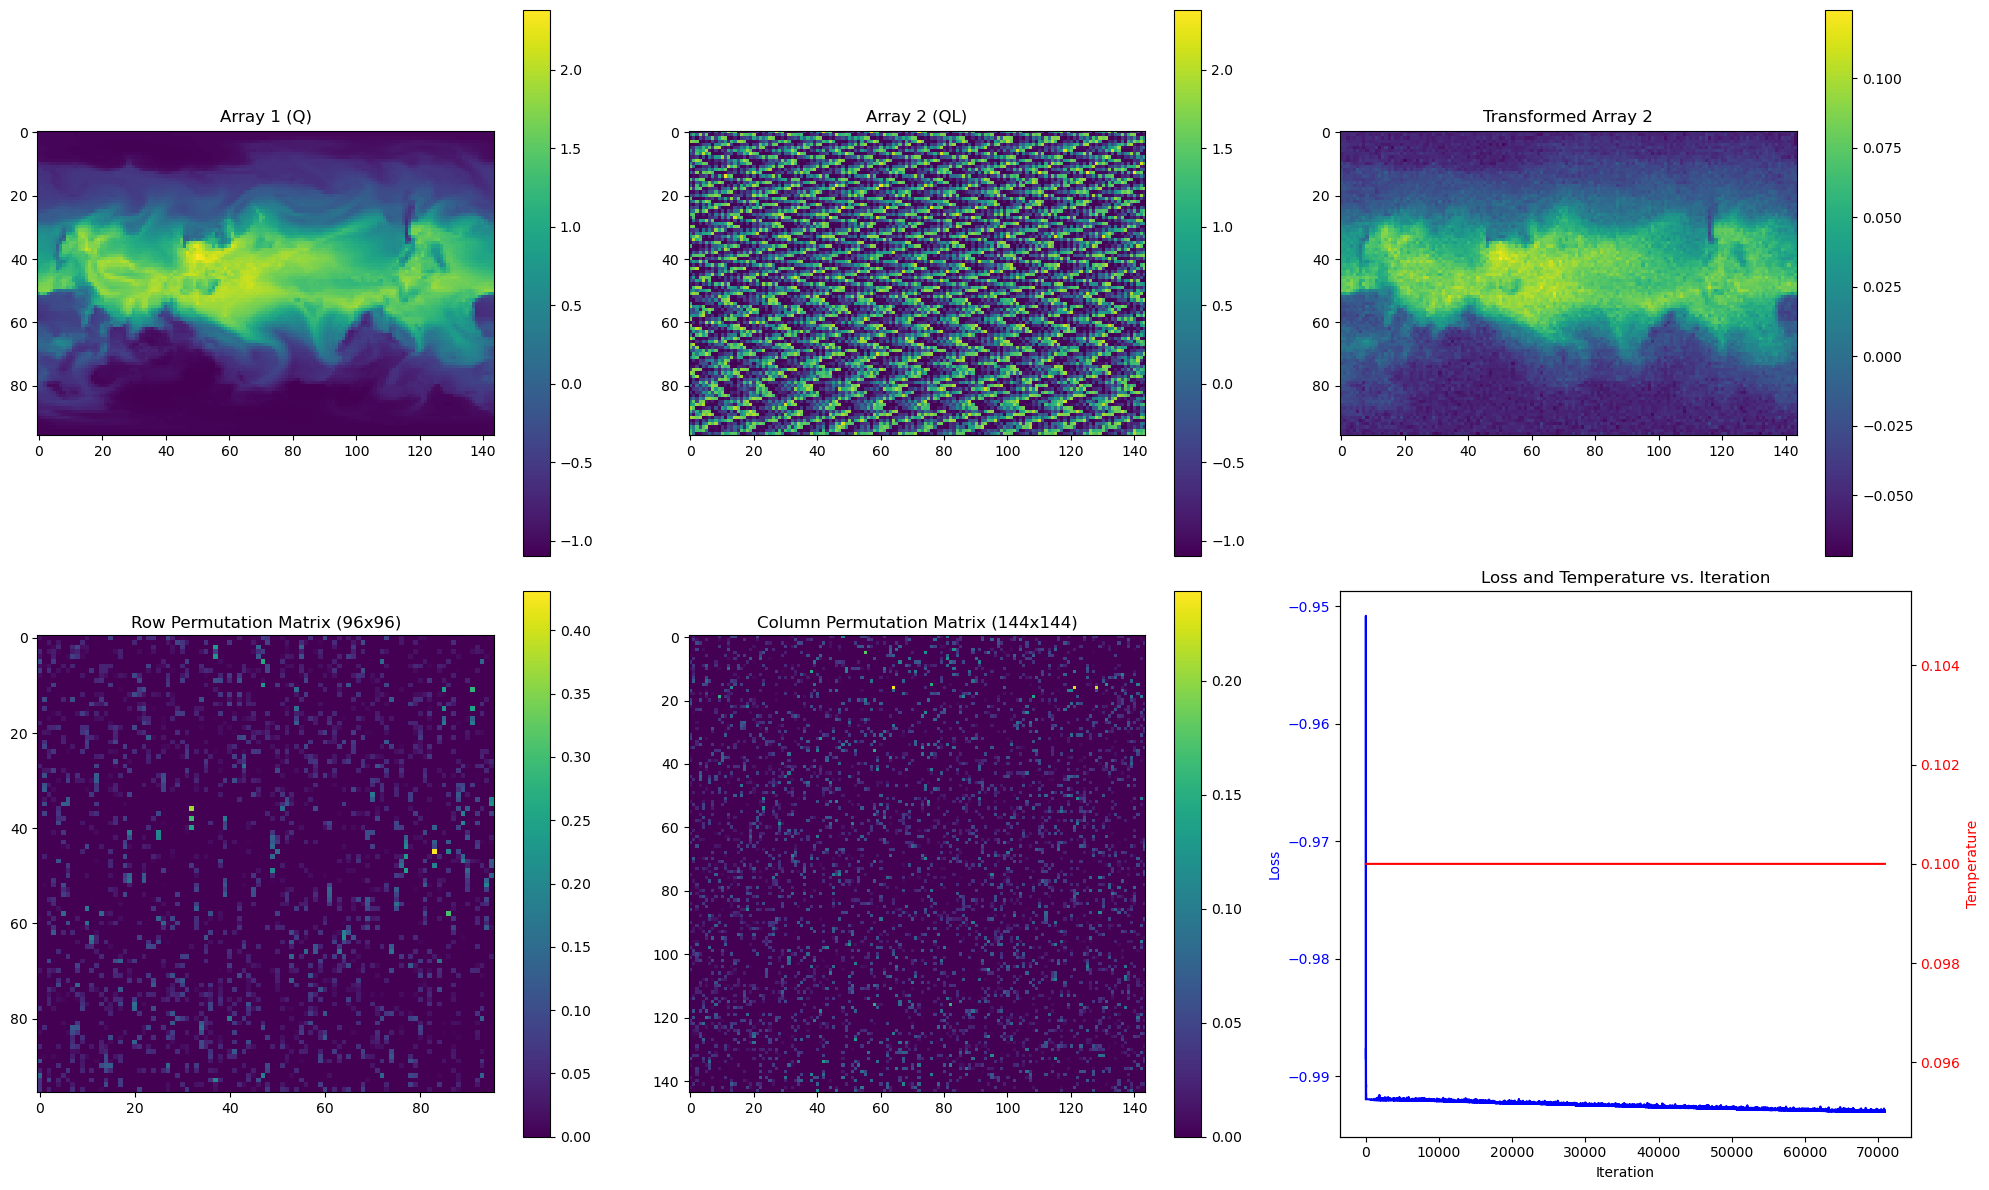

Original correlation: -0.022
Transformed correlation: 0.993
Final temperature: 0.100000


In [40]:
if best_model_state[0] is not None:
    transformer.load_state_dict(best_model_state[0])
    final_temp = best_model_state[1]


# Visualization with temperature plot
plt.figure(figsize=(20, 12))

# Original plots
plt.subplot(231)
plt.imshow(array1.numpy())
plt.title('Array 1 (Q)')
plt.colorbar()

plt.subplot(232)
plt.imshow(array2.numpy())
plt.title('Array 2 (QL)')
plt.colorbar()

# Get final transformation with very low temperature
with torch.no_grad():
    row_perm = sinkhorn(transformer.row_transform, temperature=final_temp)
    col_perm = sinkhorn(transformer.col_transform, temperature=final_temp)
    final_transformed = torch.matmul(row_perm, array2)
    final_transformed = torch.matmul(final_transformed, col_perm.t())
    
plt.subplot(233)
plt.imshow(final_transformed.numpy())
plt.title('Transformed Array 2')
plt.colorbar()

plt.subplot(234)
plt.imshow(row_perm.numpy())
plt.title('Row Permutation Matrix (96x96)')
plt.colorbar()

plt.subplot(235)
plt.imshow(col_perm.numpy())
plt.title('Column Permutation Matrix (144x144)')
plt.colorbar()

# Combined loss and temperature plot
ax1 = plt.subplot(236)
ax1.plot(losses, 'b-', label='Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(temperatures, 'r-', label='Temperature')
ax2.set_ylabel('Temperature', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Loss and Temperature vs. Iteration')
plt.tight_layout()
plt.show()

# Print final metrics
original_corr = np.corrcoef(array1.numpy().flatten(), array2.numpy().flatten())[0,1]
transformed_corr = np.corrcoef(array1.numpy().flatten(), final_transformed.numpy().flatten())[0,1]
print(f"Original correlation: {original_corr:.3f}")
print(f"Transformed correlation: {transformed_corr:.3f}")
print(f"Final temperature: {current_temp:.6f}")

In [38]:
# Save the best model state to a file
if best_model_state[0] is not None:
    save_dict = {
        'model_state': best_model_state[0],
        'temperature': best_model_state[1],
        'final_loss': min(losses),
        'correlation': transformed_corr
    }
    torch.save(save_dict, f'best_model_state0.992_{current_temp}.pt')
    print(f"Saved best model state with loss {min(losses):.6f} and correlation {transformed_corr:.3f}")


Saved best model state with loss -0.991951 and correlation 0.992


In [46]:
class SpatialTransformer(torch.nn.Module):
    def __init__(self, n_rows, n_cols):
        super().__init__()
        # Initialize close to identity
        self.row_transform = torch.nn.Parameter(torch.eye(n_rows) + 0.01 * torch.randn(n_rows, n_rows))
        self.col_transform = torch.nn.Parameter(torch.eye(n_cols) + 0.01 * torch.randn(n_cols, n_cols))
        
    def forward(self, x, temperature):
        row_perm = sinkhorn(self.row_transform, temperature=temperature)
        col_perm = sinkhorn(self.col_transform, temperature=temperature)
        
        x = torch.matmul(row_perm, x)
        x = torch.matmul(x, col_perm.t())
        return x
transformer = SpatialTransformer(96, 144)
# Load the saved model state from file
model_path = "best_model_state0.992_0.1.pt"
if os.path.exists(model_path):
    saved_state = torch.load(model_path)
    transformer.load_state_dict(saved_state['model_state'])
    current_temp = saved_state['temperature']
    print(f"Loaded model state from {model_path} with temperature {current_temp:.6f}")
else:
    print(f"Could not find saved model state at {model_path}")


Loaded model state from best_model_state0.992_0.1.pt with temperature 0.100000


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_97821/901776825.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(model_path)


In [74]:
class SpatialTransformer(torch.nn.Module):
    def __init__(self, n_rows, n_cols):
        super().__init__()
        # Initialize close to identity
        self.row_transform = torch.nn.Parameter(torch.eye(n_rows) + 0.01 * torch.randn(n_rows, n_rows))
        self.col_transform = torch.nn.Parameter(torch.eye(n_cols) + 0.01 * torch.randn(n_cols, n_cols))
        
    def forward(self, x, temperature):
        row_perm = sinkhorn(self.row_transform, temperature=temperature)
        col_perm = sinkhorn(self.col_transform, temperature=temperature)
        
        x = torch.matmul(row_perm, x)
        x = torch.matmul(x, col_perm.t())
        return x

def sinkhorn(Q, n_iterations=20, temperature=0.1):
    """
    Sinkhorn-Knopp algorithm with improved numerical stability
    """
    # Clip values to avoid overflow in exp
    Q = torch.clamp(Q, min=-20, max=20)
    Q = torch.exp(Q / max(temperature, 1e-6))
    
    for _ in range(n_iterations):
        # Add small epsilon to avoid division by zero
        row_sum = Q.sum(dim=1, keepdim=True)
        Q = torch.clamp(Q / (row_sum + 1e-6), min=1e-12, max=1e12)
        
        col_sum = Q.sum(dim=0, keepdim=True)
        Q = torch.clamp(Q / (col_sum + 1e-6), min=1e-12, max=1e12)
    return Q

def spatial_smoothness_loss(x):
    diff_h = x[:, 1:] - x[:, :-1]
    diff_v = x[1:, :] - x[:-1, :]
    return torch.mean(diff_h**2+1e-6) + torch.mean(diff_v**2+1e-6)

# Load multiple data pairs
arrays1 = []  # Q arrays
arrays2 = []  # QL arrays

# Load data from multiple files
npz_path = "/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/"
print(os.listdir(npz_path))
nc_path = "/Volumes/data_backup/experience_replay_data/replay_buffer_spinup5_seed1117_sample2_noprevQT_mix1.0_std_rbs0/nc_files/"
print(os.listdir(nc_path))

# Load N pairs (adjust N as needed)
N = 7  # Number of pairs to load
level = 29  # The vertical level we're interested in

for i in range(N):
    # Load and process NPZ file
    npz_file = f"coupled_{i}.npz"  # Adjust filename pattern as needed
    if os.path.exists(os.path.join(npz_path, npz_file)):
        print("npz_file", npz_file)
        data2 = np.load(os.path.join(npz_path, npz_file))["x"][:,level]
        data2 = data2.reshape(96,144) * data_stds["QL"] + data_means["QL"]
        print("data2.mean()", data2.mean(), "data2.std()", data2.std())
        arrays2.append(torch.tensor(data2, dtype=torch.float32).clamp(torch.finfo(torch.float16).min, torch.finfo(torch.float16).max))
        
        # Load corresponding NC file
        nc_file = f"conv_mem_share3.cam.h0.1998-01-01-{(i-1)*1800:05d}.nc"  # Adjust filename pattern
        print("nc_file", nc_file)
        if os.path.exists(os.path.join(nc_path, nc_file)):
            data1 = nc.Dataset(os.path.join(nc_path, nc_file)).variables["QL"][0,level,:,:]
            print("data1.mean()", data1.mean(), "data1.std()", data1.std())
            arrays1.append(torch.tensor(data1, dtype=torch.float32).clamp(torch.finfo(torch.float16).min, torch.finfo(torch.float16).max))

# Normalize all arrays
for i in range(len(arrays1)):
    print("arrays1[i].shape", arrays1[i].shape, arrays1[i].dtype)
    print("arrays2[i].shape", arrays2[i].shape, arrays2[i].dtype)
    print(f"before norm arrays1[{i}].mean()", arrays1[i].mean(), "arrays1[{i}].std()", arrays1[i].std())
    arrays1[i] = (arrays1[i] - arrays1[i].mean()) / arrays1[i].std()
    print(f"after norm arrays1[{i}].mean()", arrays1[i].mean(), "arrays1[{i}].std()", arrays1[i].std())
    print(f"before norm arrays2[{i}].mean()", arrays2[i].mean(), "arrays2[{i}].std()", arrays2[i].std())
    arrays2[i] = (arrays2[i] - arrays2[i].mean()) / arrays2[i].std()
    print(f"after norm arrays2[{i}].mean()", arrays2[i].mean(), "arrays2[{i}].std()", arrays2[i].std())

if True:
    # Training setup
    transformer = SpatialTransformer(96, 144)
    optimizer = Adam(transformer.parameters(), lr=0.00005)

    # Training parameters
    initial_temp = 1.0
    final_temp = 0.01
    n_epochs = 20000
    temp_schedule = np.logspace(np.log10(initial_temp), np.log10(final_temp), n_epochs)

    losses = []
    best_loss = float('inf')
    patience = 2000
    no_improvement = 0

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, min_lr=1e-6)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        current_temp = temp_schedule[epoch]
        total_loss = 0
        
        # Process all pairs in each epoch
        for i in range(len(arrays1)):
            transformed = transformer(arrays2[i], temperature=current_temp)
            
            # Combined loss with spatial smoothness
            mse_loss = F.mse_loss(transformed, arrays1[i])
            smoothness = spatial_smoothness_loss(transformed)
            # cosine_loss = -F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            cosine_loss = 1 - F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            
            # pair_loss = mse_loss + 0.1 * smoothness + 0.1 * cosine_loss
            pair_loss = 0.01 * mse_loss + 0.01 * smoothness + cosine_loss
            total_loss += pair_loss
        
        # Average loss across all pairs
        avg_loss = total_loss / len(arrays1)
        
        # Add L1 regularization
        l1_reg = 0.00001 * (torch.abs(transformer.row_transform).mean() + 
                        torch.abs(transformer.col_transform).mean())
        avg_loss = avg_loss + l1_reg
        # Check for NaN or inf loss
        if torch.isnan(avg_loss) or torch.isinf(avg_loss):
            print(f"NaN/Inf loss detected at epoch {epoch+1}. Restoring best state.")
            if best_state is not None:
                transformer.load_state_dict(best_state)
                optimizer.param_groups[0]['lr'] *= 0.5  # Reduce learning rate
            break
        
        avg_loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=0.5)
        optimizer.step()
        scheduler.step(avg_loss)
        
        losses.append(avg_loss.item())
        
        if avg_loss.item() < best_loss:
            best_loss = avg_loss.item()
            best_state = transformer.state_dict()
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Avg Loss: {avg_loss.item():.4f}, Temp: {current_temp:.6f}')

    # Evaluate final results
    transformer.load_state_dict(best_state)
    with torch.no_grad():
        final_temp = 0.01
        total_cos_sim = 0
        
        for i in range(len(arrays1)):
            transformed = transformer(arrays2[i], temperature=final_temp)
            cos_sim = F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            total_cos_sim += cos_sim
            print(f"Pair {i} cosine similarity: {cos_sim:.4f}")
        
        print(f"Average cosine similarity: {(total_cos_sim/len(arrays1)):.4f}")

['._coupled_10.npz', '._coupled_10_pred.npz', 'coupled_10.npz', '._coupled_11.npz', 'coupled_10_pred.npz', '._coupled_11_pred.npz', 'coupled_11.npz', '._coupled_12.npz', 'coupled_11_pred.npz', '._coupled_12_pred.npz', 'coupled_12.npz', '._coupled_13.npz', 'coupled_12_pred.npz', '._coupled_13_pred.npz', 'coupled_13.npz', '._coupled_14.npz', 'coupled_13_pred.npz', '._coupled_14_pred.npz', 'coupled_14.npz', '._coupled_15.npz', 'coupled_14_pred.npz', '._coupled_15_pred.npz', 'coupled_15.npz', '._coupled_16.npz', 'coupled_15_pred.npz', '._coupled_16_pred.npz', 'coupled_16.npz', '._coupled_17.npz', 'coupled_16_pred.npz', '._coupled_17_pred.npz', 'coupled_17.npz', '._coupled_18.npz', 'coupled_17_pred.npz', '._coupled_18_pred.npz', 'coupled_18.npz', '._coupled_19.npz', 'coupled_18_pred.npz', '._coupled_19_pred.npz', 'coupled_19.npz', '._coupled_20.npz', 'coupled_19_pred.npz', '._coupled_20_pred.npz', 'coupled_20.npz', '._coupled_21.npz', 'coupled_20_pred.npz', '._coupled_21_pred.npz', 'coupled

In [162]:
class SpatialTransformer(torch.nn.Module):
    def __init__(self, n_rows, n_cols):
        super().__init__()
        # Initialize close to identity
        self.row_transform = torch.nn.Parameter(torch.eye(n_rows) + 0.01 * torch.randn(n_rows, n_rows))
        self.col_transform = torch.nn.Parameter(torch.eye(n_cols) + 0.01 * torch.randn(n_cols, n_cols))
        
    def forward(self, x, temperature):
        row_perm = sinkhorn(self.row_transform, temperature=temperature)
        col_perm = sinkhorn(self.col_transform, temperature=temperature)
        
        x = torch.matmul(row_perm, x)
        x = torch.matmul(x, col_perm.t())
        return x

def sinkhorn(Q, n_iterations=20, temperature=0.1):
    """
    Sinkhorn-Knopp algorithm with improved numerical stability
    """
    # Clip values to avoid overflow in exp
    Q = torch.clamp(Q, min=-20, max=20)
    Q = torch.exp(Q / max(temperature, 1e-6))
    
    for _ in range(n_iterations):
        # Add small epsilon to avoid division by zero
        row_sum = Q.sum(dim=1, keepdim=True)
        Q = torch.clamp(Q / (row_sum + 1e-6), min=1e-12, max=1e12)
        
        col_sum = Q.sum(dim=0, keepdim=True)
        Q = torch.clamp(Q / (col_sum + 1e-6), min=1e-12, max=1e12)
    return Q

def spatial_smoothness_loss(x):
    diff_h = x[:, 1:] - x[:, :-1]
    diff_v = x[1:, :] - x[:-1, :]
    return torch.mean(diff_h**2+1e-6) + torch.mean(diff_v**2+1e-6)

# Load multiple data pairs
arrays1 = []  # Q arrays
arrays2 = []  # QL arrays

# Load data from multiple files
npz_path = "/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/"
print(os.listdir(npz_path))
nc_path = "/Volumes/data_backup/experience_replay_data/replay_buffer_spinup5_seed1117_sample2_noprevQT_mix1.0_std_rbs0/nc_files/"
print(os.listdir(nc_path))

# Load N pairs (adjust N as needed)
N = 7  # Number of pairs to load
level = 29  # The vertical level we're interested in

for i in range(N):
    # Load and process NPZ file
    npz_file = f"coupled_{i}.npz"  # Adjust filename pattern as needed
    if os.path.exists(os.path.join(npz_path, npz_file)):
        print("npz_file", npz_file)
        data2 = np.load(os.path.join(npz_path, npz_file))["x"][:,level]
        data2 = data2.reshape(96,144) * data_stds["QL"] + data_means["QL"]
        print("data2.mean()", data2.mean(), "data2.std()", data2.std())
        arrays2.append(torch.tensor(data2, dtype=torch.float32).clamp(torch.finfo(torch.float16).min, torch.finfo(torch.float16).max))
        
        # Load corresponding NC file
        nc_file = f"conv_mem_share3.cam.h0.1998-01-01-{(i-1)*1800:05d}.nc"  # Adjust filename pattern
        print("nc_file", nc_file)
        if os.path.exists(os.path.join(nc_path, nc_file)):
            data1 = nc.Dataset(os.path.join(nc_path, nc_file)).variables["QL"][0,level,:,:]
            print("data1.mean()", data1.mean(), "data1.std()", data1.std())
            arrays1.append(torch.tensor(data1, dtype=torch.float32).clamp(torch.finfo(torch.float16).min, torch.finfo(torch.float16).max))

# Normalize all arrays
for i in range(len(arrays1)):
    print("arrays1[i].shape", arrays1[i].shape, arrays1[i].dtype)
    print("arrays2[i].shape", arrays2[i].shape, arrays2[i].dtype)
    print(f"before norm arrays1[{i}].mean()", arrays1[i].mean(), "arrays1[{i}].std()", arrays1[i].std())
    arrays1[i] = (arrays1[i] - arrays1[i].mean()) / arrays1[i].std()
    print(f"after norm arrays1[{i}].mean()", arrays1[i].mean(), "arrays1[{i}].std()", arrays1[i].std())
    print(f"before norm arrays2[{i}].mean()", arrays2[i].mean(), "arrays2[{i}].std()", arrays2[i].std())
    arrays2[i] = (arrays2[i] - arrays2[i].mean()) / arrays2[i].std()
    print(f"after norm arrays2[{i}].mean()", arrays2[i].mean(), "arrays2[{i}].std()", arrays2[i].std())

if True:
    # Training setup
    transformer = SpatialTransformer(96, 144)
    optimizer = Adam(transformer.parameters(), lr=0.00005)

    # Training parameters
    initial_temp = 1.0
    final_temp = 0.01
    n_epochs = 20000
    temp_schedule = np.logspace(np.log10(initial_temp), np.log10(final_temp), n_epochs)

    losses = []
    best_loss = float('inf')
    patience = 2000
    no_improvement = 0

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, min_lr=1e-6)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        current_temp = temp_schedule[epoch]
        total_loss = 0
        
        # Process all pairs in each epoch
        for i in range(len(arrays1)):
            transformed = transformer(arrays2[i], temperature=current_temp)
            
            # Combined loss with spatial smoothness
            mse_loss = F.mse_loss(transformed, arrays1[i])
            smoothness = spatial_smoothness_loss(transformed)
            # cosine_loss = -F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            cosine_loss = 1 - F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            
            # pair_loss = mse_loss + 0.1 * smoothness + 0.1 * cosine_loss
            pair_loss = 0.01 * mse_loss + 0.01 * smoothness + cosine_loss
            total_loss += pair_loss
        
        # Average loss across all pairs
        avg_loss = total_loss / len(arrays1)
        
        # Add L1 regularization
        l1_reg = 0.00001 * (torch.abs(transformer.row_transform).mean() + 
                        torch.abs(transformer.col_transform).mean())
        avg_loss = avg_loss + l1_reg
        # Check for NaN or inf loss
        if torch.isnan(avg_loss) or torch.isinf(avg_loss):
            print(f"NaN/Inf loss detected at epoch {epoch+1}. Restoring best state.")
            if best_state is not None:
                transformer.load_state_dict(best_state)
                optimizer.param_groups[0]['lr'] *= 0.5  # Reduce learning rate
            break
        
        avg_loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=0.5)
        optimizer.step()
        scheduler.step(avg_loss)
        
        losses.append(avg_loss.item())
        
        if avg_loss.item() < best_loss:
            best_loss = avg_loss.item()
            best_state = transformer.state_dict()
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Avg Loss: {avg_loss.item():.4f}, Temp: {current_temp:.6f}')

    # Evaluate final results
    transformer.load_state_dict(best_state)
    with torch.no_grad():
        final_temp = 0.01
        total_cos_sim = 0
        
        for i in range(len(arrays1)):
            transformed = transformer(arrays2[i], temperature=final_temp)
            cos_sim = F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            total_cos_sim += cos_sim
            print(f"Pair {i} cosine similarity: {cos_sim:.4f}")
        
        print(f"Average cosine similarity: {(total_cos_sim/len(arrays1)):.4f}")

['._coupled_10.npz', '._coupled_10_pred.npz', 'coupled_10.npz', '._coupled_11.npz', 'coupled_10_pred.npz', '._coupled_11_pred.npz', 'coupled_11.npz', '._coupled_12.npz', 'coupled_11_pred.npz', '._coupled_12_pred.npz', 'coupled_12.npz', '._coupled_13.npz', 'coupled_12_pred.npz', '._coupled_13_pred.npz', 'coupled_13.npz', '._coupled_14.npz', 'coupled_13_pred.npz', '._coupled_14_pred.npz', 'coupled_14.npz', '._coupled_15.npz', 'coupled_14_pred.npz', '._coupled_15_pred.npz', 'coupled_15.npz', '._coupled_16.npz', 'coupled_15_pred.npz', '._coupled_16_pred.npz', 'coupled_16.npz', '._coupled_17.npz', 'coupled_16_pred.npz', '._coupled_17_pred.npz', 'coupled_17.npz', '._coupled_18.npz', 'coupled_17_pred.npz', '._coupled_18_pred.npz', 'coupled_18.npz', '._coupled_19.npz', 'coupled_18_pred.npz', '._coupled_19_pred.npz', 'coupled_19.npz', '._coupled_20.npz', 'coupled_19_pred.npz', '._coupled_20_pred.npz', 'coupled_20.npz', '._coupled_21.npz', 'coupled_20_pred.npz', '._coupled_21_pred.npz', 'coupled

In [161]:
# Load multiple data pairs
arrays1 = []  # Q arrays
arrays2 = []  # QL arrays

# Load data from multiple files
npz_path = "/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/"
print(os.listdir(npz_path))
nc_path = "/Volumes/data_backup/experience_replay_data/replay_buffer_spinup5_seed1117_sample2_noprevQT_mix1.0_std_rbs0/nc_files/"
print(os.listdir(nc_path))

# Load N pairs (adjust N as needed)
N = 7  # Number of pairs to load
level = 29  # The vertical level we're interested in

for i in range(N):
    # Load and process NPZ file
    npz_file = f"coupled_{i}.npz"  # Adjust filename pattern as needed
    if os.path.exists(os.path.join(npz_path, npz_file)):
        print("npz_file", npz_file)
        data2 = np.load(os.path.join(npz_path, npz_file))["x"][:,level]
        data2 = data2.reshape(96,144) * data_stds["QL"] + data_means["QL"]
        print("data2.mean()", data2.mean(), "data2.std()", data2.std())
        arrays2.append(torch.tensor(data2, dtype=torch.float32).clamp(torch.finfo(torch.float16).min, torch.finfo(torch.float16).max))
        
        # Load corresponding NC file
        nc_file = f"conv_mem_share3.cam.h0.1998-01-01-{(i-1)*1800:05d}.nc"  # Adjust filename pattern
        print("nc_file", nc_file)
        if os.path.exists(os.path.join(nc_path, nc_file)):
            data1 = nc.Dataset(os.path.join(nc_path, nc_file)).variables["QL"][0,level,:,:]
            print("data1.mean()", data1.mean(), "data1.std()", data1.std())
            arrays1.append(torch.tensor(data1, dtype=torch.float32).clamp(torch.finfo(torch.float16).min, torch.finfo(torch.float16).max))

# Normalize all arrays
for i in range(len(arrays1)):
    print("arrays1[i].shape", arrays1[i].shape, arrays1[i].dtype)
    print("arrays2[i].shape", arrays2[i].shape, arrays2[i].dtype)
    print(f"before norm arrays1[{i}].mean()", arrays1[i].mean(), "arrays1[{i}].std()", arrays1[i].std())
    arrays1[i] = (arrays1[i] - arrays1[i].mean()) / arrays1[i].std()
    print(f"after norm arrays1[{i}].mean()", arrays1[i].mean(), "arrays1[{i}].std()", arrays1[i].std())
    print(f"before norm arrays2[{i}].mean()", arrays2[i].mean(), "arrays2[{i}].std()", arrays2[i].std())
    arrays2[i] = (arrays2[i] - arrays2[i].mean()) / arrays2[i].std()
    print(f"after norm arrays2[{i}].mean()", arrays2[i].mean(), "arrays2[{i}].std()", arrays2[i].std())

if True:
    # Training setup
    # transformer = SpatialTransformer(96, 144)
    optimizer = Adam(transformer.parameters(), lr=0.001)

    # Training parameters
    initial_temp = 0.01
    final_temp = 0.01
    n_epochs = 20000
    temp_schedule = np.logspace(np.log10(initial_temp), np.log10(final_temp), n_epochs)

    losses = []
    best_loss = float('inf')
    patience = 2000
    no_improvement = 0

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, min_lr=1e-6)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        current_temp = temp_schedule[epoch]
        total_loss = 0
        
        # Process all pairs in each epoch
        for i in range(len(arrays1)):
            transformed = transformer(arrays2[i], temperature=current_temp)
            
            # Combined loss with spatial smoothness
            mse_loss = F.mse_loss(transformed, arrays1[i])
            smoothness = spatial_smoothness_loss(transformed)
            # cosine_loss = -F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            cosine_loss = 1 - F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            
            pair_loss = mse_loss + 0.1 * smoothness + 0.1 * cosine_loss
            # pair_loss = 0.01 * mse_loss + 0.01 * smoothness + cosine_loss
            total_loss += pair_loss
        
        # Average loss across all pairs
        avg_loss = total_loss / len(arrays1)
        
        # Add L1 regularization
        l1_reg = 0.00001 * (torch.abs(transformer.row_transform).mean() + 
                        torch.abs(transformer.col_transform).mean())
        avg_loss = avg_loss + l1_reg
        # Check for NaN or inf loss
        if torch.isnan(avg_loss) or torch.isinf(avg_loss):
            print(f"NaN/Inf loss detected at epoch {epoch+1}. Restoring best state.")
            if best_state is not None:
                transformer.load_state_dict(best_state)
                optimizer.param_groups[0]['lr'] *= 0.5  # Reduce learning rate
            break
        
        avg_loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=0.5)
        optimizer.step()
        scheduler.step(avg_loss)
        
        losses.append(avg_loss.item())
        
        if avg_loss.item() < best_loss:
            best_loss = avg_loss.item()
            best_state = transformer.state_dict()
            no_improvement = 0
        else:
            no_improvement += 1
            
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Avg Loss: {avg_loss.item():.4f}, Temp: {current_temp:.6f}')

    # Evaluate final results
    transformer.load_state_dict(best_state)
    with torch.no_grad():
        final_temp = 0.01
        total_cos_sim = 0
        
        for i in range(len(arrays1)):
            transformed = transformer(arrays2[i], temperature=final_temp)
            cos_sim = F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
            total_cos_sim += cos_sim
            print(f"Pair {i} cosine similarity: {cos_sim:.4f}")
        
        print(f"Average cosine similarity: {(total_cos_sim/len(arrays1)):.4f}")

['._coupled_10.npz', '._coupled_10_pred.npz', 'coupled_10.npz', '._coupled_11.npz', 'coupled_10_pred.npz', '._coupled_11_pred.npz', 'coupled_11.npz', '._coupled_12.npz', 'coupled_11_pred.npz', '._coupled_12_pred.npz', 'coupled_12.npz', '._coupled_13.npz', 'coupled_12_pred.npz', '._coupled_13_pred.npz', 'coupled_13.npz', '._coupled_14.npz', 'coupled_13_pred.npz', '._coupled_14_pred.npz', 'coupled_14.npz', '._coupled_15.npz', 'coupled_14_pred.npz', '._coupled_15_pred.npz', 'coupled_15.npz', '._coupled_16.npz', 'coupled_15_pred.npz', '._coupled_16_pred.npz', 'coupled_16.npz', '._coupled_17.npz', 'coupled_16_pred.npz', '._coupled_17_pred.npz', 'coupled_17.npz', '._coupled_18.npz', 'coupled_17_pred.npz', '._coupled_18_pred.npz', 'coupled_18.npz', '._coupled_19.npz', 'coupled_18_pred.npz', '._coupled_19_pred.npz', 'coupled_19.npz', '._coupled_20.npz', 'coupled_19_pred.npz', '._coupled_20_pred.npz', 'coupled_20.npz', '._coupled_21.npz', 'coupled_20_pred.npz', '._coupled_21_pred.npz', 'coupled

KeyboardInterrupt: 

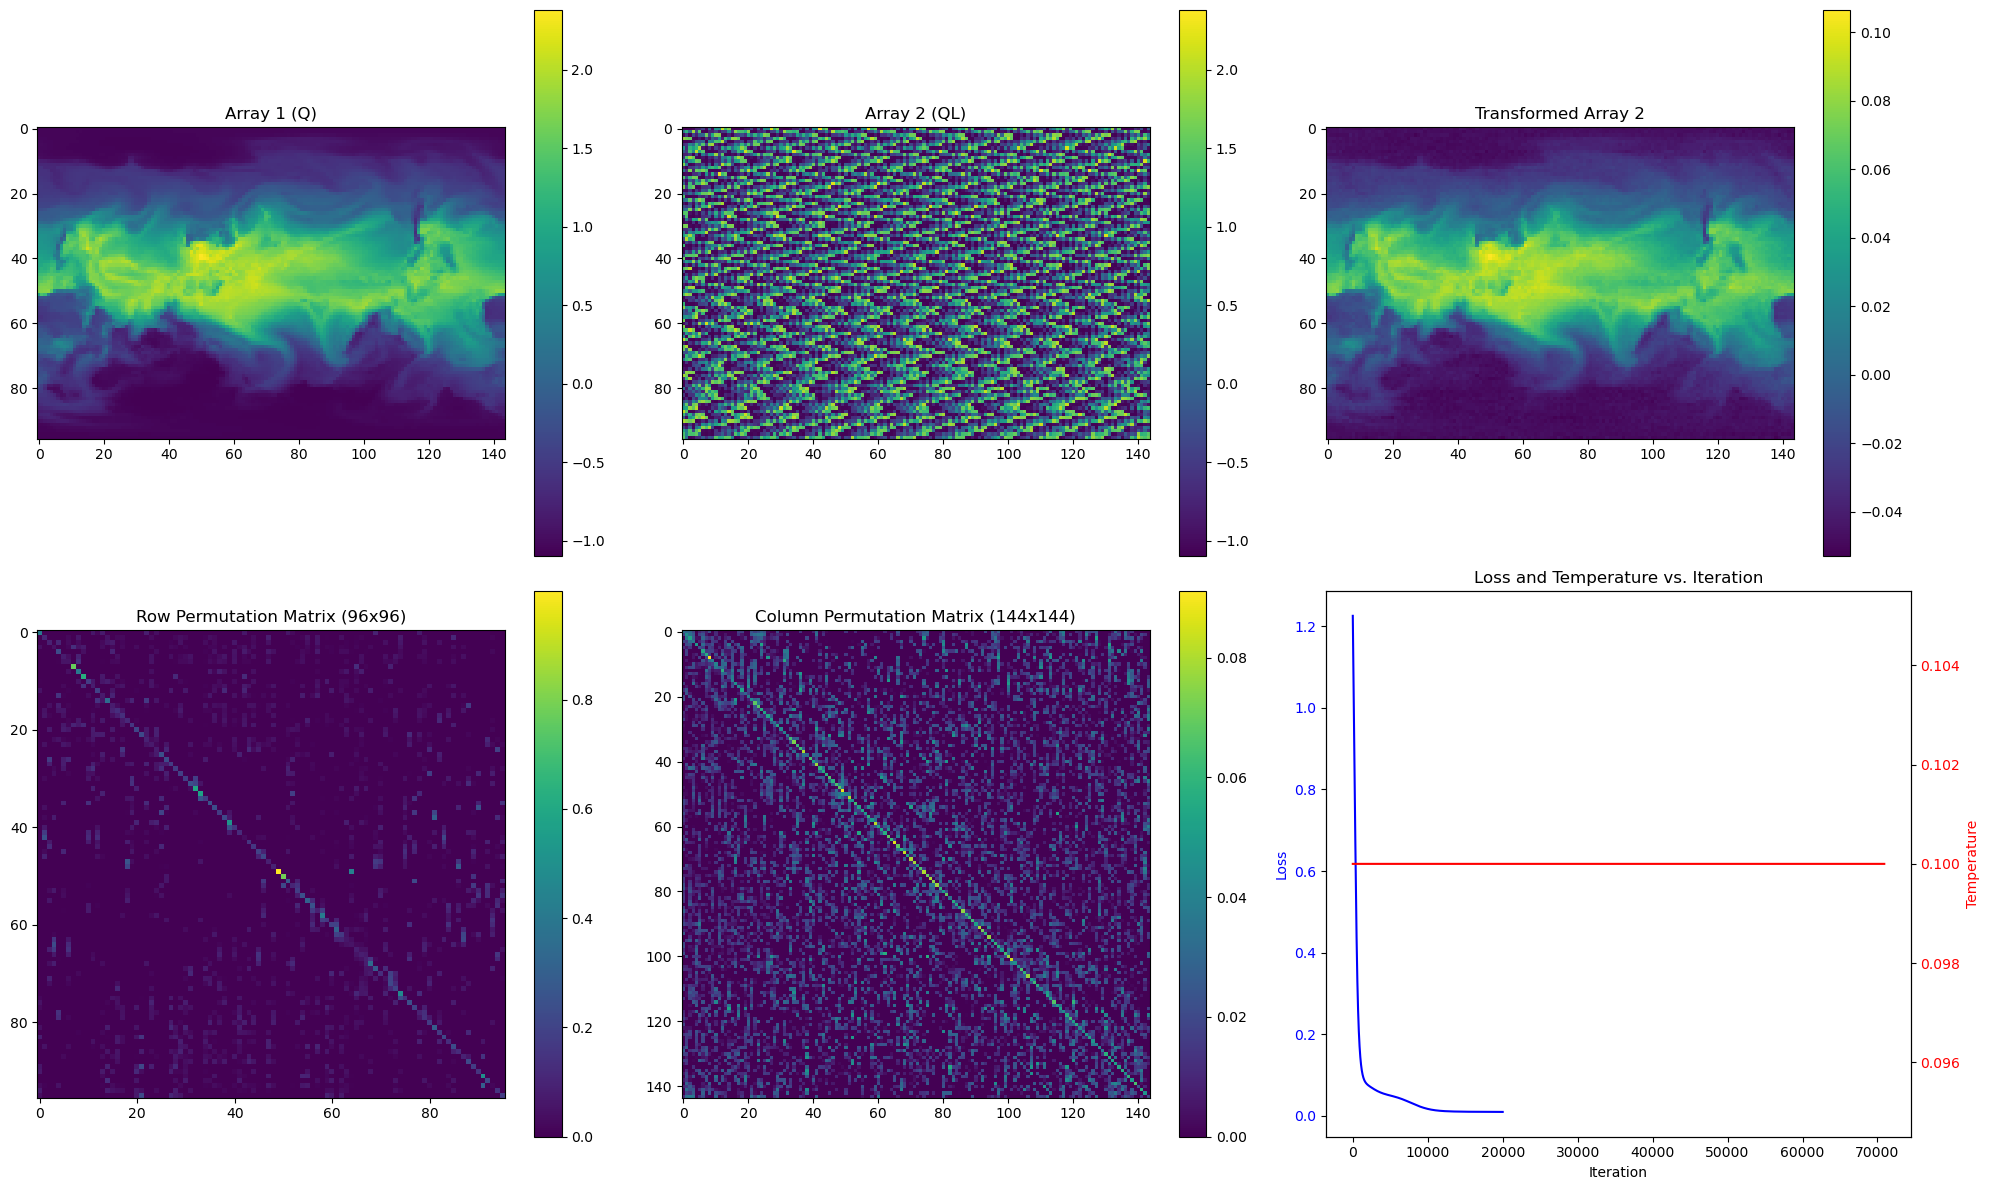

Original correlation: -0.022
Transformed correlation: 0.999
Final temperature: 0.010000


In [163]:
# if best_model_state[0] is not None:
#     transformer.load_state_dict(best_model_state[0])
#     final_temp = best_model_state[1]
# transformer = SpatialTransformer(96, 144)
# transformer.load_state_dict(best_state)
# final_temp = 0.01


# Visualization with temperature plot
plt.figure(figsize=(20, 12))

# Original plots
plt.subplot(231)
plt.imshow(array1.numpy())
plt.title('Array 1 (Q)')
plt.colorbar()

plt.subplot(232)
plt.imshow(array2.numpy())
plt.title('Array 2 (QL)')
plt.colorbar()

# Get final transformation with very low temperature
with torch.no_grad():
    # Get permutation matrices using Sinkhorn
    row_perm = sinkhorn(transformer.row_transform, temperature=final_temp)
    col_perm = sinkhorn(transformer.col_transform, temperature=final_temp)
    
    # Apply row permutation first
    final_transformed = torch.matmul(row_perm, array2)
    
    # Then apply column permutation
    final_transformed = torch.matmul(final_transformed, col_perm.t())
    
    # Ensure values stay in valid range
    # final_transformed = torch.clamp(final_transformed, min=0.0)
    
plt.subplot(233)
plt.imshow(final_transformed.numpy())
plt.title('Transformed Array 2')
plt.colorbar()

plt.subplot(234)
plt.imshow(row_perm.numpy())
plt.title('Row Permutation Matrix (96x96)')
plt.colorbar()

plt.subplot(235)
plt.imshow(col_perm.numpy())
plt.title('Column Permutation Matrix (144x144)')
plt.colorbar()

# Combined loss and temperature plot
ax1 = plt.subplot(236)
ax1.plot(losses, 'b-', label='Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(temperatures, 'r-', label='Temperature')
ax2.set_ylabel('Temperature', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Loss and Temperature vs. Iteration')
plt.tight_layout()
plt.show()

# Print final metrics
original_corr = np.corrcoef(array1.numpy().flatten(), array2.numpy().flatten())[0,1]
transformed_corr = np.corrcoef(array1.numpy().flatten(), final_transformed.numpy().flatten())[0,1]
print(f"Original correlation: {original_corr:.3f}")
print(f"Transformed correlation: {transformed_corr:.3f}")
print(f"Final temperature: {current_temp:.6f}")

In [164]:
best_state = torch.load('best_transformer_state2.pt')
transformer.load_state_dict(best_state)
with torch.no_grad():
    final_temp = 0.01
    total_cos_sim = 0
    
    for i in range(len(arrays1)):
        transformed = transformer(arrays2[i], temperature=final_temp)
        cos_sim = F.cosine_similarity(transformed.flatten(), arrays1[i].flatten(), dim=0)
        total_cos_sim += cos_sim
        print(f"Pair {i} cosine similarity: {cos_sim:.4f}")
    
    print(f"Average cosine similarity: {(total_cos_sim/len(arrays1)):.4f}")

Pair 0 cosine similarity: 0.9993
Pair 1 cosine similarity: 0.9994
Pair 2 cosine similarity: 0.9995
Pair 3 cosine similarity: 0.9988
Average cosine similarity: 0.9993


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_97821/1773463790.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state = torch.load('best_transformer_sta

In [76]:
# Save best model state to file
model_path = 'best_transformer_state.pt'
torch.save(best_state, model_path)
print(f"Saved best model state to {model_path}")


Saved best model state to best_transformer_state.pt


In [81]:
# Save best model state to file
model_path = 'best_transformer_state2.pt'
torch.save(best_state, model_path)
print(f"Saved best model state to {model_path}")

Saved best model state to best_transformer_state2.pt


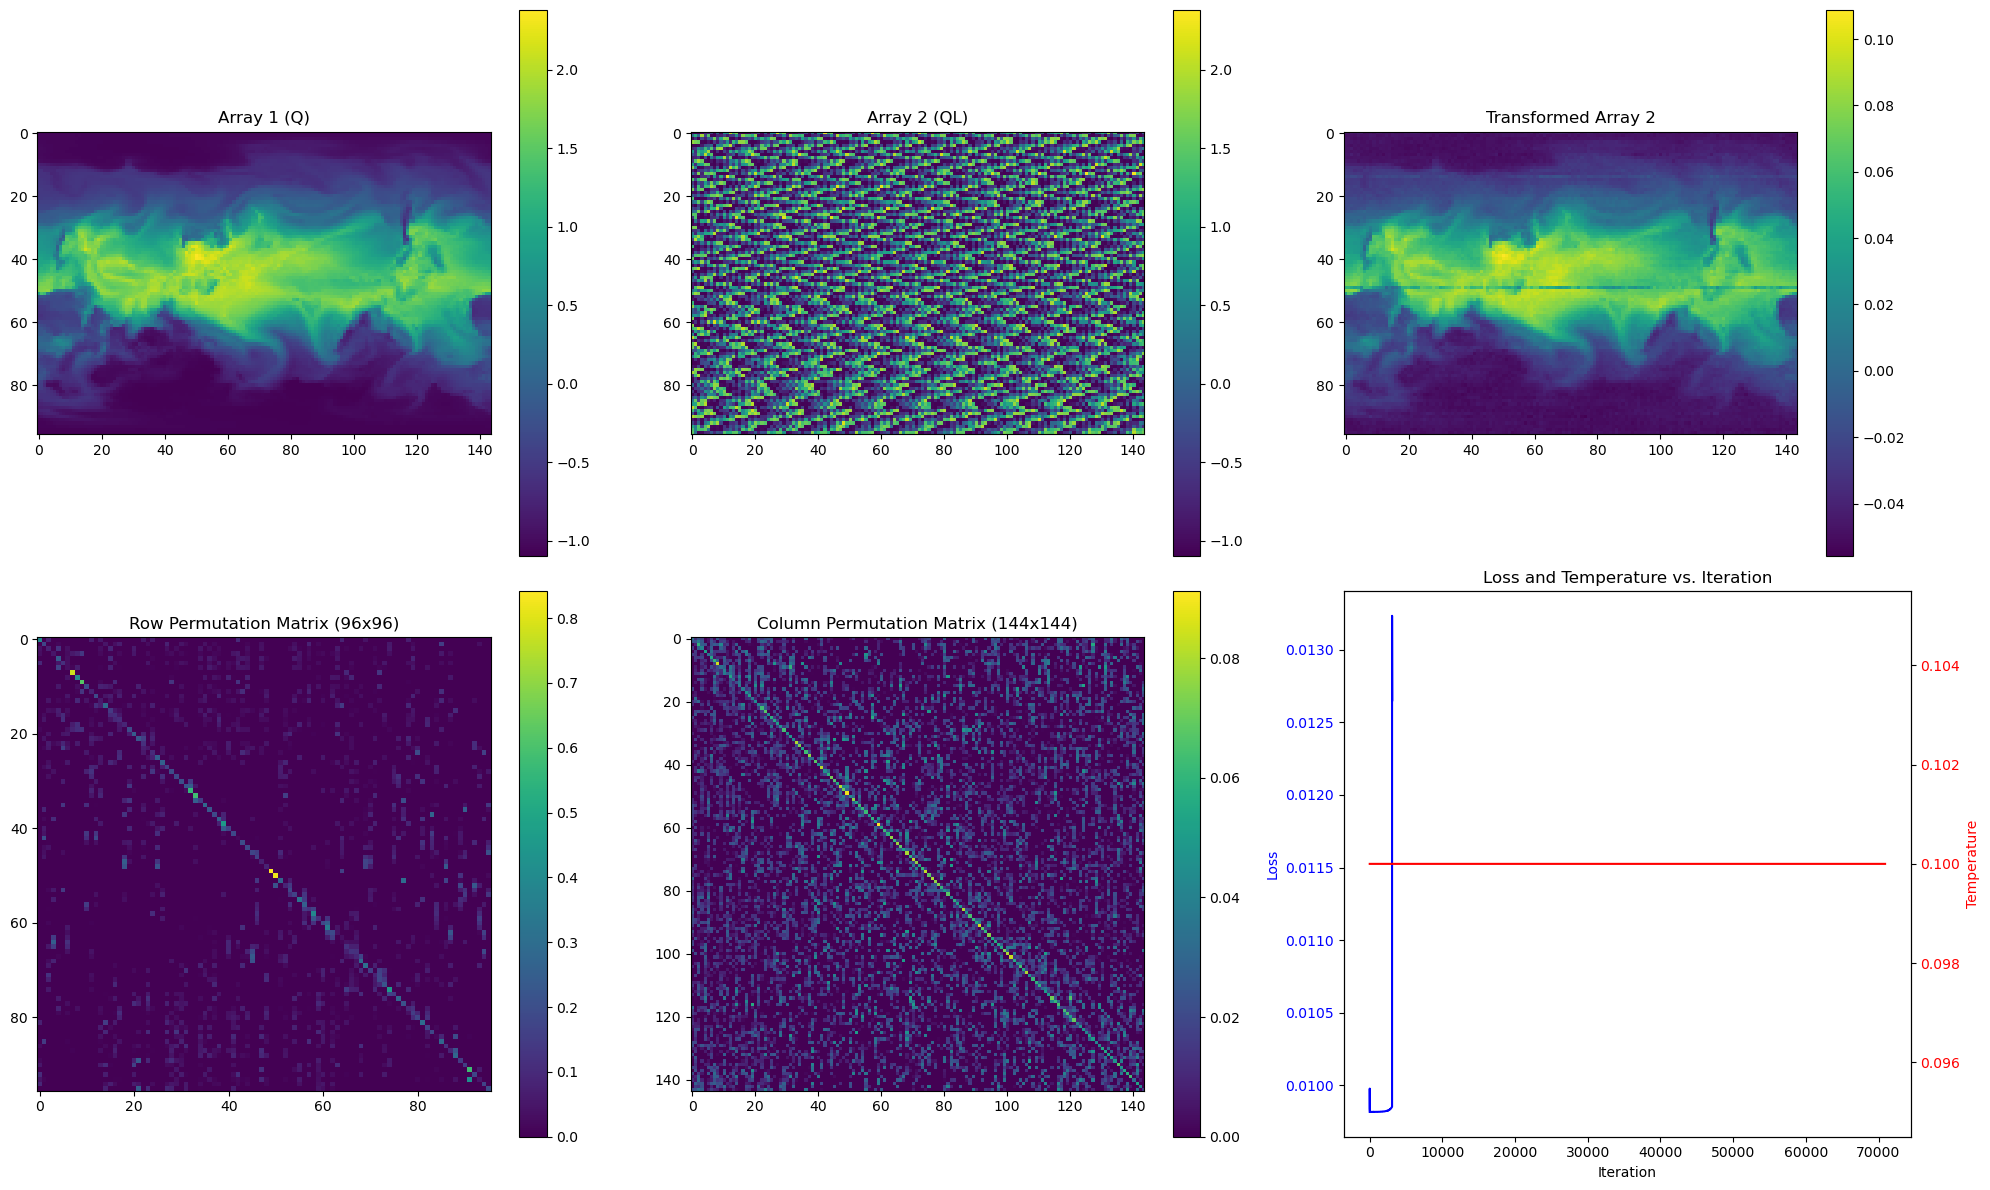

Original correlation: -0.022
Transformed correlation: 0.997
Final temperature: 0.006997


In [149]:
# if best_model_state[0] is not None:
#     transformer.load_state_dict(best_model_state[0])
#     final_temp = best_model_state[1]
# transformer = SpatialTransformer(96, 144)
# transformer.load_state_dict(best_state)
# final_temp = 0.01


# Visualization with temperature plot
plt.figure(figsize=(20, 12))

# Original plots
plt.subplot(231)
plt.imshow(array1.numpy())
plt.title('Array 1 (Q)')
plt.colorbar()

plt.subplot(232)
plt.imshow(array2.numpy())
plt.title('Array 2 (QL)')
plt.colorbar()

# Get final transformation with very low temperature
with torch.no_grad():
    # Get permutation matrices using Sinkhorn
    row_perm = sinkhorn(transformer.row_transform, temperature=final_temp)
    col_perm = sinkhorn(transformer.col_transform, temperature=final_temp)
    
    # Apply row permutation first
    final_transformed = torch.matmul(row_perm, array2)
    
    # Then apply column permutation
    final_transformed = torch.matmul(final_transformed, col_perm.t())
    
    # Ensure values stay in valid range
    # final_transformed = torch.clamp(final_transformed, min=0.0)
    
plt.subplot(233)
plt.imshow(final_transformed.numpy())
plt.title('Transformed Array 2')
plt.colorbar()

plt.subplot(234)
plt.imshow(row_perm.numpy())
plt.title('Row Permutation Matrix (96x96)')
plt.colorbar()

plt.subplot(235)
plt.imshow(col_perm.numpy())
plt.title('Column Permutation Matrix (144x144)')
plt.colorbar()

# Combined loss and temperature plot
ax1 = plt.subplot(236)
ax1.plot(losses, 'b-', label='Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(temperatures, 'r-', label='Temperature')
ax2.set_ylabel('Temperature', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Loss and Temperature vs. Iteration')
plt.tight_layout()
plt.show()

# Print final metrics
original_corr = np.corrcoef(array1.numpy().flatten(), array2.numpy().flatten())[0,1]
transformed_corr = np.corrcoef(array1.numpy().flatten(), final_transformed.numpy().flatten())[0,1]
print(f"Original correlation: {original_corr:.3f}")
print(f"Transformed correlation: {transformed_corr:.3f}")
print(f"Final temperature: {current_temp:.6f}")

In [138]:
# Load transformer from saved file
transformer = SpatialTransformer(96, 144)
best_state = torch.load('best_transformer_state2.pt')
transformer.load_state_dict(best_state)

def apply_transformation(transformer, data):
    """
    Apply learned transformation to new data
    
    Args:
        transformer: dict containing row_perm and col_perm matrices
        data: torch tensor of shape (lat, lon) to transform
        
    Returns:
        transformed_data: torch tensor of transformed data
    """

    # Apply row permutation first
    transformed = torch.matmul(transformer['row_perm'], data)
    
    # Then apply column permutation 
    transformed = torch.matmul(transformed, transformer['col_perm'].t())
    
    return transformed


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_97821/454348061.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state = torch.load('best_transformer_stat

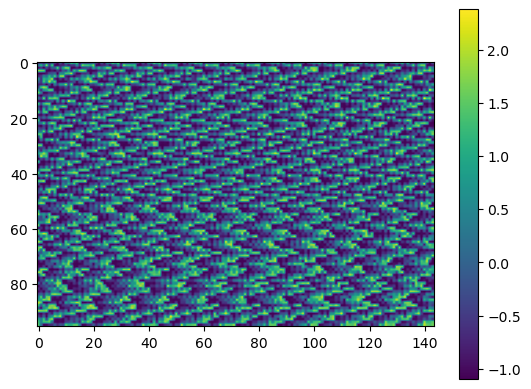

In [139]:
plt.imshow(array2.numpy())
plt.colorbar()
plt.show()

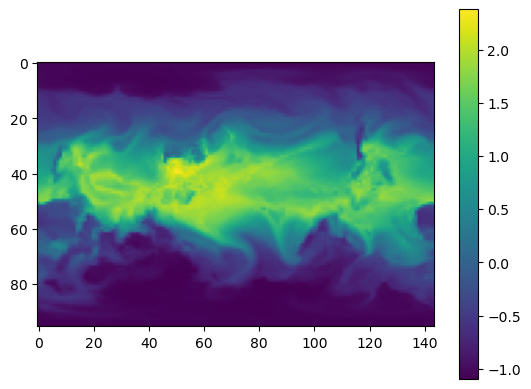

In [140]:
plt.imshow(array1.numpy())
plt.colorbar()
plt.show()

In [141]:
transformered_array = apply_transformation(transformer, array2)
plt.imshow(transformered_array.numpy())
plt.colorbar()
plt.show()


TypeError: 'SpatialTransformer' object is not subscriptable

In [212]:
import matplotlib.pyplot as plt
import numpy as np

python_output = np.load("python_output.npy")
print(python_output.shape)
cesm_output = np.load("cesm_output.npy")
print(cesm_output.shape)
cesm_flatten = cesm_output.flatten()
python_flatten = python_output.flatten()


(96, 144)
(96, 144)


In [213]:
mappings = []
for i in range(96):
    sub_mapping = []
    for j in range(144*i,144*(i+1)):
        cesm_value = cesm_flatten[j]
        sub_mapping.append(np.argmin((python_flatten - cesm_value)**2))
    mappings.append(sub_mapping)

print(mappings)


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1955, 1970, 1985, 2000, 2015, 3890, 4840, 4855, 4870, 4885, 4900, 5775, 5790, 5805, 5820, 5835, 6715, 6730, 6745, 6760, 6775, 8170, 8185, 8200, 2030, 2045, 2060, 2075, 2090, 4915, 4930, 4945, 4960, 4975, 9035, 9050, 9065, 9080, 9095, 10989, 11004, 11019, 11034, 11759, 11774, 11789, 11804, 11819, 2105, 2120, 2135, 2150, 2165, 4990, 5005, 5020, 5035, 5050, 8665, 8680, 8695, 8710, 8725, 10669, 11834, 11849, 11864, 11879, 11894, 12604, 13752, 13767, 2180, 2195, 2210, 2225, 2240, 5065, 5080, 5095, 5110, 5125, 7015, 7030, 7045, 7060, 7075, 8740, 8755, 8770, 8785, 

In [214]:
mappings = np.array(mappings)
print(mappings.shape)

(96, 144)


In [215]:
python_reordered = []
for i in range(96):
    python_reordered.append(python_flatten[mappings[i]])

In [216]:
python_reordered = np.array(python_reordered)
print(python_reordered.shape)

(96, 144)


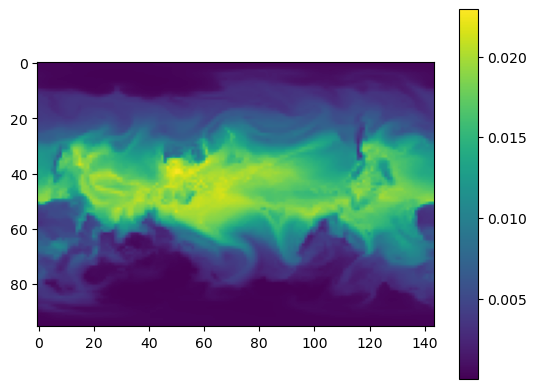

In [217]:
plt.imshow(python_reordered.reshape(96,144))
plt.colorbar()
plt.show()


In [225]:
def reorder3(data):
    # Get number of variables N from input shape
    n_vars = data.shape[1] if len(data.shape) > 1 else 1
    
    # Initialize return array with shape (96*144, N)
    ret = np.empty([96*144, n_vars])
    
    # For each grid point
    for i in range(96):
        for j in range(144):
            # Calculate output index
            out_idx = i*144 + j
            # Copy all variables for this point using the mapping
            if len(data.shape) == 1:
                ret[out_idx] = data[mappings[i][j]]
            else:
                ret[out_idx,:] = data[mappings[i][j],:]
            
    return ret




In [220]:
np.save("python_mappings.npy", mappings)

(96, 144)
(96, 144)


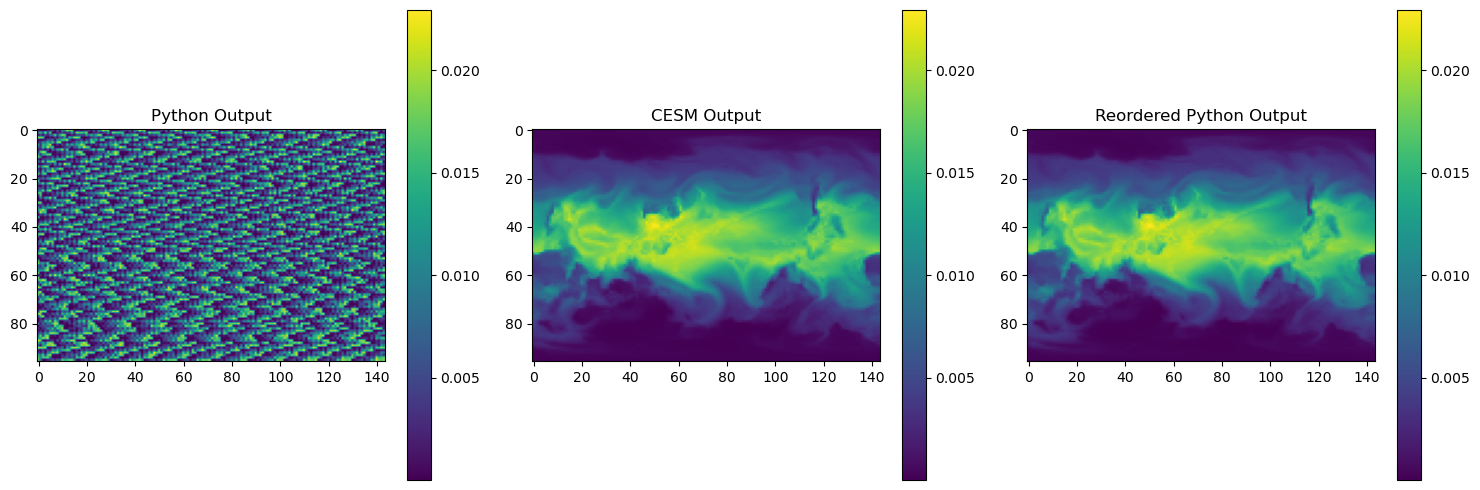

In [226]:
import numpy as np
import matplotlib.pyplot as plt
def reorder(data, pver):
    # data[lon*lat, pver]
    lon_p = 24
    lat_p = 3
    # lon_num = 6
    # lat_num = 32

    ret = np.empty([144*96, pver])

    start_lon = 0  # (st: st+lon_p)
    start_lat = 0  # (st: st+lat_p)
    idx = 0

    for i in range(192):
        for lat_i in range(0, lat_p):
            for lon_i in range(0, lon_p):
                lon_idx = start_lon + lon_i
                lat_idx = start_lat + lat_i
                new_idx = lat_idx * 144 + lon_idx
                for k in range(0, pver):
                    ret[new_idx][k] = data[idx][k]
                idx = idx + 1
        start_lon = start_lon + lon_p
        if (start_lon == 144):
            start_lon = 0
            start_lat = start_lat + lat_p

    return ret
python_output = np.load("python_output.npy")
print(python_output.shape)
cesm_output = np.load("cesm_output.npy")
print(cesm_output.shape)
reordered_python = reorder3(python_output.flatten())
# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot python_output
im1 = ax1.imshow(python_output)
ax1.set_title('Python Output')
plt.colorbar(im1, ax=ax1)

# Plot cesm_output 
im2 = ax2.imshow(cesm_output)
ax2.set_title('CESM Output')
plt.colorbar(im2, ax=ax2)

# Plot reordered_python
im3 = ax3.imshow(reordered_python.reshape(96,144))
ax3.set_title('Reordered Python Output')
plt.colorbar(im3, ax=ax3)
plt.tight_layout()
plt.show()


In [227]:
crash_final = np.load("/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_53.npz")

In [230]:
reordered_x = reorder3(crash_final['x'])

In [232]:
print(reordered_x.shape)

(13824, 309)


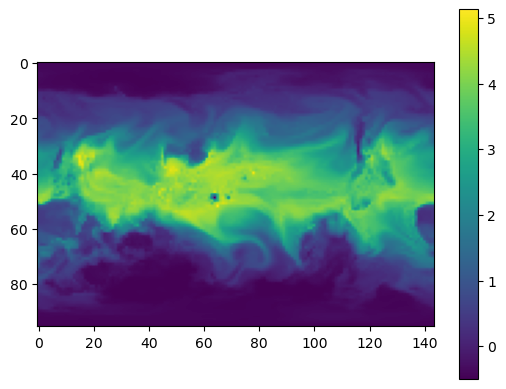

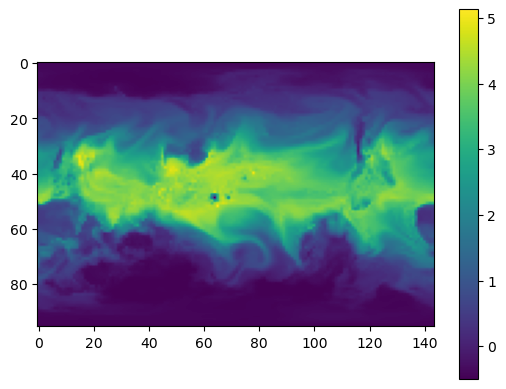

In [234]:
plt.imshow(reordered_x[:,29].reshape(96,144))
plt.colorbar()
plt.show()

plt.imshow(reordered_x[:,29].reshape(96,144))
plt.colorbar()
plt.show()